# Forecasting Inflation: Romanian Case Study Using SARIMA Models

In this article, we look at (i) how to merge [Datastream](https://www.refinitiv.com/en/products/datastream-macroeconomic-analysis) and [Eikon](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api) / [Refinitiv Data Platform (RDP)](https://developers.refinitiv.com/en/api-catalog/refinitiv-data-platform/refinitiv-data-platform-apis) data in Python and (ii) how one may choose an optimal SARIMA model by selecting the one with lowest in-sample errors. We also look into how one may use both Eikon and Datastream data together, as well as statistical concepts of stationarity and differencing among others. We also investigate and compare models only using comparative months (*e.g.*: Jan. with Jan., Feb. with Feb., *etc.*).

We find that the optimal model is a SARIMA(5,0,4)(4,0,0)$_{12}$.

To do so we look at (i) how one may check for stationarity graphically and via (ADF, KPSS & PP) test statistics, (ii) differencing, (iii) ex-ante (before modelling) parameter identification via autocorrelation & partial autocorrelation functions, (iv) the difference between Autoregressive Moving Average (ARMA) & Seasonal Integrated ARMA (SARIMA) models, (v) ex-post (after modelling) parameter identification via information criteria and mean of absolute & squared errors (as well as the use of Python's 'pickle' library), (vi) how one may choose an optimal model specification - reducing errors, (vii) recursive one-step-ahead out-of-sample forecasts, and finally (iix) corresponding month models before concluding.

As a precursor to ARMA modelling, the reader is advised to look read '[Information Demand and Stock Return Predictability (Coded in R): Part 2: Econometric Modelling of Non-Linear Variances](https://developers.refinitiv.com/en/article-catalog/article/information-demand-and-stock-return-predictability-coded-in-r-part-2)' - an article without coding that looks into our methods of modelling.

## Contents

* [What are SARIMA Models?](#whataresarimamodels)
* [Get to Coding](#gettothecoding)
    * [Development Tools & Resources](#developmenttoolsandresources)
    * [Import Libraries](#importlibraries)
* [Data Sets](#datasets)
    * [Collecting Datastream Data](#collectingdatastreamdata)
    * [Collecting Eikon data](#collectingeikondata)
    * [Joining the Datastream and Eikon data-frames together](#joiningthedatastreamandeikondataframestogether)
* [Stationarity](#stationarity)
    * [Checking For Stationarity Via Graphical Analysis](#checkingforstationarityviagraphicalanalysis)
    * [Checking For Stationarity Via Test Statistics](#checkingforstationarityviateststatistics)
        * [Interpreting the stationarity table](#Interpretingthestationaritytable)
    * [Differencing](#differencing)
* [Modelling](#modelling)
    * [Ex-Ante Parameter Identification: Autocorrelation and Partial Autocorrelation Functions](#exanteparameteridentification)
        * [ARMA(5,2)](#ARMA52)
        * [SARIMA(5,0,2)(1, 0, 0)12](#SARIMA50210012)
    * [Ex-Post Parameter Identification: Information Criteria and Mean of Absolute & squared Errors](#expostparameteridentification)
        * [Graphical Analysis](#graphicalanalysis)
        * [Information Criteria](#informationcriteria)
        * [Mean Squared Errors and Sum of squared Errors](#meansquarederrorsandsumofsquarederrors)
            * [Pickle](#pickle)
            * [pmdarima](#pmdarima)
    * [Optimal Model](#optimalmodel)
        * [Fitted values of our 'Optimal Model'](#Fittedvaluesofouroptimalmodel)
        * [Recursive One-Step-Ahead Out-of-Sample Forecasts](#recursiveonestepaheadoutofsampleforecasts)
    * [corresponding Month Model](#correspondingmonthmodel)
        * [Check the best SAMIMA model with ARMA(0,0) imposed](#first)
        * [Fit the sarima0,0,0,3,0,0,12 model](#second)
        * [Recursive One-Step-Ahead Out-of-Sample Forecasts](#third)
    * [Comparing Models](#comparingmodels)
* [Conclusion](#conclusion)
* [References](#references)

## What are SARIMA Models? <a class="anchor" id="whataresarimamodels"></a>

Seasonal AutoRegressive Integrated Moving Average (SARIMA) models are best explained in a separate  article. "[Time Series Forecasting with SARIMA in Python](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b)" is great at showing both the mathematics and fundamental Python basics at play below. I would suggest reading [this article](https://developers.refinitiv.com/en/article-catalog/article/information-demand-and-stock-return-predictability-coded-in-r-part-2) 1st that goes through the slightly simpler ARMA model.

## Get to Coding <a class="anchor" id="gettothecoding"></a>

### Development Tools & Resources <a class="anchor" id="developmenttoolsandresources"></a>
The example code demonstrating the use case is based on the following development tools and resources:

- Refinitiv's [DataStream](https://www.refinitiv.com/en/products/datastream-macroeconomic-analysis) Web Services (DSWS): Access to DataStream data. A DataStream or Refinitiv Workspace IDentification (ID) will be needed to run the code below.
- Refinitiv's [Eikon API](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api): To access Eikon data. An [Eikon API key](https://developers.refinitiv.com/en/api-catalog/eikon/eikon-data-api/quick-start) will be needed to use this API.

### Import Libraries <a class="anchor" id="importlibraries"></a>

We need to gather our data. Since **Refinitiv's [DataStream](https://www.refinitiv.com/en/products/datastream-macroeconomic-analysis) Web Services (DSWS)** allows for access to ESG data covering nearly 70% of global market cap and over 400 metrics, naturally it is more than appropriate. We can access DSWS via the Python library "DatastreamDSWS" that can be installed simply by using $\textit{pip install}$.

In [1]:
import DatastreamDSWS as dsws

# We can use our Refinitiv's Datastream Web Socket (DSWS) API keys that allows us to be identified by Refinitiv's back-end services and enables us to request (and fetch) data: Credentials are placed in a text file so that it may be used in this code without showing it itself.
(dsws_username, dsws_password) = (open("Datastream_username.txt","r"),
                                  open("Datastream_password.txt","r"))

ds = dsws.Datastream(username = str(dsws_username.read()),
                     password = str(dsws_password.read()))

# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to.
dsws_username.close()
dsws_password.close()


# # Alternatively one can use the following:
# import getpass
# dsusername = input()
# dspassword = getpass.getpass()
# ds = dsws.Datastream(username = dsusername, password = dspassword)

We use **Refinitiv's [Eikon Python Application Programming Interface (API)](https://developers.refinitiv.com/eikon-apis/eikon-data-api)** to access financial data such as [Clc1](cpurl://apps.cp./cms/?pageId=oil-future-template&st=RIC&s=CLc1). We can access it via the Python library "eikon" that can be installed simply by using $\textit{pip install}$.

In [2]:
import eikon as ek

# The key is placed in a text file so that it may be used in this code without showing it itself:
eikon_key = open("eikon.txt","r")
ek.set_app_key(str(eikon_key.read()))
# It is best to close the files we opened in order to make sure that we don't stop any other services/programs from accessing them if they need to:
eikon_key.close()

In [3]:
import numpy as np
import pandas as pd
import pickle # need to ' pip install pickle-mixin '. This library is native to Python and therefore doesn't have a version of its own.
from datetime import datetime, timedelta # ' datetime ' is native to Python and therefore doesn't have a version of its own.

In [4]:
# Import the relevant plotting libraries:

import plotly # Needed to show plots in line in Notebook.
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected = False) # Initialize plotly.js in the browser if it hasn't been loaded into the Document Object Model (DOM) yet.

import cufflinks, seaborn # Needed to show plots in line in Notebook.
cufflinks.go_offline() # plotly & cufflinks are online platforms but we want to stay offline.

In [5]:
for i,j in zip([ek, np, pd, plotly, cufflinks, seaborn],
               ["eikon", "numpy", "pandas", "plotly", "cufflinks", "seaborn"]):
    print("The library '" + j + "' in this notebook is version " + i.__version__)

The library 'eikon' in this notebook is version 1.1.8
The library 'numpy' in this notebook is version 1.18.2
The library 'pandas' in this notebook is version 1.2.4
The library 'plotly' in this notebook is version 4.14.3
The library 'cufflinks' in this notebook is version 0.17.3
The library 'seaborn' in this notebook is version 0.11.1


## Data-sets <a class="anchor" id="datasets"></a>

* Dependent variables (Y):

    * RMCPANNL: [Romania, Consumer Prices, by Commodity, All Items, Total, Change y/y](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMCPANNL&prev=99_RMGOVBALA&prev_csrc=12)
    
        Annual inflation rate – the increase (in percentage term) in consumer prices in one month of the current year compared to the same month of the previous year. This rate is calculated as a ratio, expressed as a percentage, between the price index of one month of the current year and that of the same month of the previous year, calculated against the same base, from which 100 is subtracted.
    
        This data-set will be differenced once to be stationary.

    * RMCONPRCF


* Independent / Explanatory variables (X):

    Each of the following datasetes can be used in 'raw' (*id est* (*i.e.*): without changing the data retrieved from Datastream) or adjusted like RMCPANNL (i.e.: looking at that metric's increase in one month compared to the same month of the previous year and then differenced once to be stationary) each defined as 'raw' or 'yoy' variables respectively.
    
    * RMUNPTOTP: [Romania, Unemployed, Overall, Registered](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMUNPTOTP&prev=99_RMGOVBALA&prev_csrc=12).
    * CLc1: ['CLc1 NYMEX Light Sweet Crude Oil (WTI) Electronic Energy Future Continuation 1'](cpurl://apps.cp./cms/?pageId=oil-future-template&st=RIC&s=CLc1) on eikon (which we will use) and ['NYMEX - Light Crude Oil TRC1'](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=NYMEX+-+Light+Crude+Oil+TRC1&prev=99_CLc1) on Datastream: Crude oil prices from the US market's [NYMEX (New York Mercantile Exchange)](https://www.cmegroup.com/company/nymex.html).
    * RMXRUSD.: [Romania, New Romanian Leu Per US Dollar, RON](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMXRUSD&prev=99_NYMEX+-+Light+Crude+Oil+TRC1&prev_csrc=15): Foreign Exchange (FX) rate of 1[USD](https://www.investopedia.com/terms/u/usd.asp) to 1[Leu](https://www.investopedia.com/terms/forex/r/ron-romanian-new-leu.asp).
    * RMXREUR.: [Romania, New Romanian Leu Per Euro, RON](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMXREUR.&prev=99_RMXRUSD&prev_csrc=12): Foreign Exchange (FX) rate of 1EUR to 1Leu.
    * RMGOVBALA: [Romania, Deficit / Surplus, GFS2001, Total (New Methodology Since January 2006), Cumulative, RON](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMGOVBALA&prev=99_RMXREUR.&prev_csrc=12): Romanian Government's [National Debt level](https://www.investopedia.com/updates/usa-national-debt/). If this value is positive, it indicates a surplus; if it is negative, it indicates a deficit.

Due to popular demand, we decided not to use [Consumer Prices (Romania, Consumer Prices, by Commodity, All Items, Total, Index, Corresponding Period of the Previous Year = 100)](https://product.datastream.com/browse/search.aspx?dsid=ZRQW955&AppGroup=DSAddin&q=RMCPY...F&prev=99_RMCONPRCF&prev_csrc=12) as a dependent variable, but RMCPANNL instead.

### Collecting Datastream Data <a class="anchor" id="collectingdatastreamdata"></a>

We can go ahead and collect our data from Datastream:

In [6]:
df = ds.get_data(tickers = "RMCPANNL,RMUNPTOTP,RMXRUSD.,RMXREUR.,RMGOVBALA", # be careful not to put spaces in between elements here, or else these spaces will be included in column names.
                 fields = "X",
                 start = '2000-01-01',
                 end = '2021-04-06',
                 freq = 'M')

Note that RMCPANNL's values are percentages, we thus ought to divide it by 100 to get proper fractions:

In [7]:
df["RMCPANNL", "X"] = df["RMCPANNL"]["X"]/100

Let's have a look at our Pandas data-frame ' df '

In [8]:
df

Instrument RMCPANNL RMUNPTOTP RMXRUSD. RMXREUR. RMGOVBALA
Field             X         X        X        X         X
Dates                                                    
2000-01-15   0.5680    1175.0     1.84   1.8636    -162.8
2000-02-15   0.5570    1196.6     1.87   1.8421    -461.9
2000-03-15   0.4900    1166.7     1.92   1.8538    -826.0
2000-04-15   0.4890    1139.2     1.98   1.8713   -1210.9
2000-05-15   0.4400    1097.4     2.04   1.8507   -1367.8
...             ...       ...      ...      ...       ...
2020-12-15   0.0206     296.1     4.00   4.8707 -105906.6
2021-01-15   0.0299     292.2     4.00   4.8728    -112.3
2021-02-15   0.0316     293.5     4.03   4.8741   -8430.8
2021-03-15   0.0305       NaN     4.11   4.8878       NaN
2021-04-15      NaN       NaN      NaN      NaN       NaN

[256 rows x 5 columns]

**Note on timing**: I aim to make this article as realistic as possible, putting myself in the shoes of a professional using this workflow to predict inflation. I do not expect our SARIMA models to perform particularly well, mainly because we did not do extensive research on the best exogenous variables to use - I leave that to you to decide. But while I do not expect this model to perform well, the workflow ought to be at its best. To use it optimally, please try to use exogenous variables (such as ```RMXRUSD.```) as soon as their monthly values are released. It is possible for the values as of the - 15th of the month - of one variable to be published at another time to another (*exempli gratia* (*e.g.*): values for ```RMXRUSD.``` and ```RMGOVBALA``` could be published on the 20th and 25th of the month respectively, even though they are both representing values for the 15th of the month).

The 'X' is the default value for each of the items we requested. Let's change those with relevant value names:

In [9]:
df.columns = pd.MultiIndex.from_tuples(
    [('RMCPANNL', 'yoy'), # yoy will be the increase in one month compared to the same month of the previous year
     ('RMUNPTOTP', 'raw'),
     ('RMXRUSD.', 'raw'),
     ('RMXREUR.', 'raw'),
     ('RMGOVBALA', 'raw')],
    names=['Instrument', 'Field'])

### Collecting Eikon data <a class="anchor" id="collectingeikondata"></a>

Now let's add our CLc1 data from Eikon. Note that we want monthly data, so let's collect monthly (30 day) moving average data (```MAVG(TR.CLOSEPRICE,-29)```). 1st let's collect that data:

In [10]:
CLc1, err = ek.get_data(
    instruments = "CLc1",
    fields = ["TR.CLOSEPRICE.timestamp",
              "TR.CLOSEPRICE",
              "MAVG(TR.CLOSEPRICE,-29)"],
    parameters = {'SDate': '1999-01-01', # We want to start 1 year earlier because we're about to take moving averages which makes us loose degrees of freedom.
                  'EDate': str(datetime.today())[:10], # ' df.index[-1] ' picks the last date in our previously defined data-frame ' df '. You may want to use 'str(datetime.today())[:10]'.
                  'FRQ': 'D'})
CLc1

Instrument             Timestamp  Close Price  MAVG(TR.CLOSEPRICE,-29)
0          CLc1  1999-01-01T00:00:00Z         <NA>                11.547667
1          CLc1  1999-01-04T00:00:00Z        12.36                11.566667
2          CLc1  1999-01-05T00:00:00Z         12.0                   11.611
3          CLc1  1999-01-06T00:00:00Z        12.85                   11.646
4          CLc1  1999-01-07T00:00:00Z        13.05                11.683333
...         ...                   ...          ...                      ...
5592       CLc1  2021-04-13T00:00:00Z        60.45                61.643103
5593       CLc1  2021-04-14T00:00:00Z        62.75                     <NA>
5594       CLc1  2021-04-15T00:00:00Z        63.32                     <NA>
5595       CLc1  2021-04-16T00:00:00Z        63.07                     <NA>
5596       CLc1  2021-04-19T00:00:00Z         <NA>                     <NA>

[5597 rows x 4 columns]

But note that the last few moving average data points are ```NaN```. Just in case these last few days are useful, let's make our own moving average:

In [11]:
# This takes the moving average of the last 30 datapoints, not the last 30 days (since not all of the last 30 days might have been trading days with price data).
CLc1["CLc1 30D Moving Average"] = CLc1["Close Price"].dropna().rolling(30).mean()

In [12]:
# Let's remove the ' MAVG(TR.CLOSEPRICE,-29) ' column, it was only there to display the issue outlined.
CLc1.drop('MAVG(TR.CLOSEPRICE,-29)', axis = 1, inplace = True)

In [13]:
CLc1 # Let's have a look at our data-frame now.

Instrument             Timestamp  Close Price  CLc1 30D Moving Average
0          CLc1  1999-01-01T00:00:00Z         <NA>                      NaN
1          CLc1  1999-01-04T00:00:00Z        12.36                      NaN
2          CLc1  1999-01-05T00:00:00Z         12.0                      NaN
3          CLc1  1999-01-06T00:00:00Z        12.85                      NaN
4          CLc1  1999-01-07T00:00:00Z        13.05                      NaN
...         ...                   ...          ...                      ...
5592       CLc1  2021-04-13T00:00:00Z        60.45                61.645000
5593       CLc1  2021-04-14T00:00:00Z        62.75                61.754333
5594       CLc1  2021-04-15T00:00:00Z        63.32                61.829667
5595       CLc1  2021-04-16T00:00:00Z        63.07                61.797667
5596       CLc1  2021-04-19T00:00:00Z         <NA>                      NaN

[5597 rows x 4 columns]

### Joining the Datastream and Eikon data-frames together <a class="anchor" id="joiningthedatastreamandeikondataframestogether"></a>

Now, if we want to combine the data from df and CLc1, we may want to do so [joining](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) the two data-frames on their dates; but no may notice that CLc1's Timestamp and df's index (Dates) portray time in different ways:

In [14]:
CLc1.Timestamp[0] # Note that ' CLc1.Timestamp ' is the same as CLc1["Timestamp"]

'1999-01-01T00:00:00Z'

In [15]:
df.index[0]

'2000-01-15'

To harmonize the two, I will use df's way:

In [16]:
'2000-01-31T00:00:00Z'[0:10]

'2000-01-31'

In [17]:
CLc1.index = [i[0:10] for i in CLc1.Timestamp]
CLc1

Instrument             Timestamp  Close Price  \
1999-01-01       CLc1  1999-01-01T00:00:00Z         <NA>   
1999-01-04       CLc1  1999-01-04T00:00:00Z        12.36   
1999-01-05       CLc1  1999-01-05T00:00:00Z         12.0   
1999-01-06       CLc1  1999-01-06T00:00:00Z        12.85   
1999-01-07       CLc1  1999-01-07T00:00:00Z        13.05   
...               ...                   ...          ...   
2021-04-13       CLc1  2021-04-13T00:00:00Z        60.45   
2021-04-14       CLc1  2021-04-14T00:00:00Z        62.75   
2021-04-15       CLc1  2021-04-15T00:00:00Z        63.32   
2021-04-16       CLc1  2021-04-16T00:00:00Z        63.07   
2021-04-19       CLc1  2021-04-19T00:00:00Z         <NA>   

            CLc1 30D Moving Average  
1999-01-01                      NaN  
1999-01-04                      NaN  
1999-01-05                      NaN  
1999-01-06                      NaN  
1999-01-07                      NaN  
...                             ...  
2021-04-13                61.645000  
2021-04-14                61.754333  
2021-04-15                61.829667  
2021-04-16                61.797667  
2021-04-19                      NaN  

[5597 rows x 4 columns]

Now we are encountering the issue whereby the 15th of the month every month is not necessarily a trading day. But we want to normalise the two data-frames to have monthly data on the 15th of every month (since that's how Datastream returns data). What we can do is use ```CLc1 30D Moving Average``` on the 15th of every month and (if it's not available) we'll use the 14th's; if that's unavailable we'll use the 13th; and so on until a set limit - say the 12th of every month (repeating this process 3 times). This is what the function below does:

In [18]:
def Match_previous_days(df1, df2, common_day = 15, back = 3):
    """Match_previous_days Version 1.0:
    This function compares two Pandas data-frames (df1 and df2, with monthly and daily
    data respectively and dates in its index), and checks if any index from df1 is
    missing in df2. If one for a day set in 'common_day' is missing, it changes it to
    the previous day. It does so as many times as is set in 'back'.
    It is created to ease the joining of Datastream API (DSWS) and Eikon API
    retrieved Pandas data-frames (df1 and df2 respectively). E.g.:
    Setting ' common_day ' to ' 15 ' and back to ' 3 ', our function will scan for
    any row-name (called an index) in df1 for the 15th of the month that does not
    appear in df2 and change any such index name to the 14th of the month (essentially
    showing df2 data for the 14th of the month for those rows specifically as 15th of
    the month). It can do it again for the 13th of the month, and then 12th; 3 times 
    in total (as specified in ' back ').
    
    
    Parameters:
    ----------
     
    df1: Pandas data-frame
        A monthly data-frame from DSWS - or formatted similarly
        (i.e.: with Multi-Index'ed columns, etc.).
     
    df2: Pandas data-frame
        A daily data-frame from eikon's API - or formatted
        similarly - with one exception that its index is made of strings for dates in the
        "yyyy-mm-dd" format.
    
    common_day: int
        The day of the month to start from. For an example, see 1st
        paragraph above.
        Default: common_day = 15
    
    common_day: int
        The number of times we are ready to run the procedure for. For an
        example, see 1st paragraph above.
        Default: back = 3
    
    
    Dependencies:
    ----------
    
    pandas 1.2.3
    numpy 1.19.5
    
    
    Examples:
    --------
    
    >>> import DatastreamDSWS as dsws
    >>> ds = dsws.Datastream(username = "insert dsws username here", password = "insert dsws password here")
    >>> 
    >>> import eikon as ek
    >>> ek.set_app_key("insert eikon key here")
    >>> 
    >>> df_1 = ds.get_data(tickers = "RMCPANNL,RMUNPTOTP,RMXRUSD.,RMXREUR.,RMGOVBALA", # be carefulnot to put spaces in between elements here, or else these spaces will be included in column names.
    >>>                    fields = "X", start = '2000-01-01', freq = 'M')
    >>> 
    >>> df_2, err = ek.get_data(instruments = "CLc1", fields = ["TR.CLOSEPRICE.timestamp", "TR.CLOSEPRICE"],
    >>>                         parameters = {'SDate': '1999-01-01', # We want to start 1 year earlier because we're about to take moving averages which makes us loose degrees of freedom.
    >>>                                       'EDate': str(datetime.today())[:10], # ' df_1.index[-1] ' picks the last date in our previously defined data-frame ' df_1 '. You may want to use 'str(datetime.today())[:10]'.
    >>>                                       'FRQ': 'D'})
    >>> df_2["CLc1 30D Moving Average"] = df_2["Close Price"].rolling(30).mean() # This takes the moving average of the last 30 datapoints, not the last 30 days (since not all of the last 30 days might have been trading days with price data).
    >>> df_2.index = [i[0:10] for i in CLc1.Timestamp]
    >>> 
    >>> Match_previous_days(df1 = df_1, df2 = df_2, common_day = 15, back = 3) # Note that this is the same as ' Match_previous_days(df1 = df_1, df2 = df_2) '.
    """
    
    _common_day = "-" + "{:02d}".format(common_day)
    df2_list = []
    df2_df1_diff_index1 = []
    df2_df1_diff_index2 = []
    index_dictionary = []
    
    df2_list.append(df2.copy())
    
    for k in range(back):
        
        if k > 0:
            df2_list.append(df2_list[-1])
        
        df2_df1_diff_index1.append(np.setdiff1d(
            df1.index.tolist(),
            df2_list[k][df2_list[k].index.str.contains(_common_day)].index.tolist()))
        
        df2_df1_diff_index2.append([
            i.replace("-15",  "-" + "{:02d}".format(common_day - 1 - k)) # ' -1 ' because k starts at 0.
            for i in df2_df1_diff_index1[k]])
        
        index_dictionary.append({})
#         display(index_dictionary[k])
        for i,j in zip(df2_df1_diff_index2[k], df2_df1_diff_index1[k]):
            index_dictionary[k][i] = j
#         display(index_dictionary[k])
        
        df2_list[k].rename(index = index_dictionary[k], inplace = True)
        
    return df2_list[-1]

In [19]:
CLc1_of_interest0 = Match_previous_days(df1 = df, df2 = CLc1, common_day = 15, back = 4) # Applying the previously defined function.

In [20]:
CLc1_of_interest0.iloc[258:261]

Instrument             Timestamp  Close Price  \
2000-01-13       CLc1  2000-01-13T00:00:00Z        26.69   
2000-01-15       CLc1  2000-01-14T00:00:00Z         28.0   
2000-01-18       CLc1  2000-01-18T00:00:00Z        28.85   

            CLc1 30D Moving Average  
2000-01-13                25.831667  
2000-01-15                25.945333  
2000-01-18                26.075333

As per the above, we can see the difference between the index and ```Timestamp``` in row 259, indicating that our function above worked.

In [21]:
CLc1_of_interest1 = CLc1_of_interest0[CLc1_of_interest0.index.str.contains("-15")] # We're only interested in the 15th of each month.

CLc1_of_interest = pd.DataFrame(
    data = CLc1_of_interest1[
        ["Close Price", "CLc1 30D Moving Average"] # We're only interested in those two columns.
    ].values,
    index = CLc1_of_interest1.index,
    columns = pd.MultiIndex.from_tuples(
        [('CLc1', 'Close Price'),
         ('CLc1', 'Close Price 30D Moving Average')]))

CLc1_of_interest

CLc1                               
           Close Price Close Price 30D Moving Average
1999-01-15       12.18                            NaN
1999-03-15       14.46                      12.606667
1999-04-15       16.88                      15.517667
1999-06-15       18.54                         17.667
1999-07-15        20.2                         18.655
...                ...                            ...
2020-12-15       47.59                         43.203
2021-01-15       52.04                      48.701333
2021-02-15       59.73                         53.606
2021-03-15       65.28                      60.805333
2021-04-15       63.32                      61.829667

[265 rows x 2 columns]

Now we can join our two data-frames:

In [22]:
df = pd.merge(df, CLc1_of_interest,
              left_index = True,
              right_index = True)
df

Instrument RMCPANNL RMUNPTOTP RMXRUSD. RMXREUR. RMGOVBALA        CLc1  \
Field           yoy       raw      raw      raw       raw Close Price   
2000-01-15   0.5680    1175.0     1.84   1.8636    -162.8        28.0   
2000-02-15   0.5570    1196.6     1.87   1.8421    -461.9       30.03   
2000-03-15   0.4900    1166.7     1.92   1.8538    -826.0       30.65   
2000-04-15   0.4890    1139.2     1.98   1.8713   -1210.9        25.4   
2000-05-15   0.4400    1097.4     2.04   1.8507   -1367.8       29.97   
...             ...       ...      ...      ...       ...         ...   
2020-12-15   0.0206     296.1     4.00   4.8707 -105906.6       47.59   
2021-01-15   0.0299     292.2     4.00   4.8728    -112.3       52.04   
2021-02-15   0.0316     293.5     4.03   4.8741   -8430.8       59.73   
2021-03-15   0.0305       NaN     4.11   4.8878       NaN       65.28   
2021-04-15      NaN       NaN      NaN      NaN       NaN       63.32   

Instrument                                 
Field      Close Price 30D Moving Average  
2000-01-15                      25.945333  
2000-02-15                      27.650333  
2000-03-15                         30.256  
2000-04-15                      28.145667  
2000-05-15                         26.414  
...                                   ...  
2020-12-15                         43.203  
2021-01-15                      48.701333  
2021-02-15                         53.606  
2021-03-15                      60.805333  
2021-04-15                      61.829667  

[256 rows x 7 columns]

Now, we want comparable data, and RMCPANNL is the only series depicting the increase in one month compared to the same month of the previous year. So let's transform our other series to depict the data similarly:

In [23]:
df["RMUNPTOTP", "yoy"] = df["RMUNPTOTP"]["raw"].pct_change(periods = 12)
df["RMXRUSD.", "yoy"] = df["RMXRUSD."]["raw"].pct_change(periods = 12)
df["RMXRUSD.", "yoy"] = df["RMXRUSD."]["raw"].pct_change(periods = 12)
df["RMXREUR.", "yoy"] = df["RMXREUR."]["raw"].pct_change(periods = 12)
df["RMGOVBALA", "yoy"] = df["RMGOVBALA"]["raw"].pct_change(periods = 12)
df["CLc1", "yoy"] = df["CLc1"][
    "Close Price 30D Moving Average"].pct_change(periods = 12)
df = df.sort_index(axis=1)

In [24]:
df = df.dropna()
df

Instrument        CLc1                                          RMCPANNL  \
Field      Close Price Close Price 30D Moving Average       yoy      yoy   
2001-01-15       30.05                         28.535  0.099812   0.3990   
2001-02-15        28.8                      29.811333  0.078155   0.4000   
2001-03-15       26.58                         28.976 -0.042306   0.4030   
2001-04-15        28.2                          27.25 -0.031823   0.3750   
2001-05-15       28.98                      27.932667  0.057495   0.3740   
...                ...                            ...       ...      ...   
2020-10-15       40.92                      39.479333 -0.290909   0.0224   
2020-11-15       40.12                      39.577333 -0.283577   0.0214   
2020-12-15       47.59                         43.203 -0.248931   0.0206   
2021-01-15       52.04                      48.701333 -0.189239   0.0299   
2021-02-15       59.73                         53.606 -0.028114   0.0316   

Instrument RMGOVBALA           RMUNPTOTP           RMXREUR.            \
Field            raw       yoy       raw       yoy      raw       yoy   
2001-01-15    -306.1  0.880221    1032.9 -0.120936   2.4646  0.322494   
2001-02-15    -601.2  0.301580    1032.3 -0.137306   2.4729  0.342435   
2001-03-15    -865.2  0.047458     992.8 -0.149053   2.4849  0.340436   
2001-04-15   -1087.5 -0.101908     948.4 -0.167486   2.4880  0.329557   
2001-05-15   -1404.5  0.026831     890.8 -0.188263   2.4910  0.345977   
...              ...       ...       ...       ...      ...       ...   
2020-10-15  -76512.0  1.815788     285.7  0.104368   4.8733  0.025138   
2020-11-15  -85981.9  1.474314     290.7  0.120663   4.8699  0.021307   
2020-12-15 -105906.6  1.202753     296.1  0.148119   4.8707  0.019551   
2021-01-15    -112.3 -0.842607     292.2  0.128621   4.8728  0.019734   
2021-02-15   -8430.8 -0.198989     293.5  0.143358   4.8741  0.019089   

Instrument RMXRUSD.            
Field           raw       yoy  
2001-01-15     2.62  0.423913  
2001-02-15     2.68  0.433155  
2001-03-15     2.73  0.421875  
2001-04-15     2.79  0.409091  
2001-05-15     2.85  0.397059  
...             ...       ...  
2020-10-15     4.14 -0.037209  
2020-11-15     4.12 -0.044084  
2020-12-15     4.00 -0.069767  
2021-01-15     4.00 -0.071926  
2021-02-15     4.03 -0.079909  

[242 rows x 12 columns]

## Stationarity <a class="anchor" id="stationarity"></a>

You may wonder why we spoke of differencing our data above. This is because our data may not be [stationary](https://people.duke.edu/~rnau/411diff.htm). We need to verify that our data is stationary (for more information as to why, please see [here](https://developers.refinitiv.com/en/article-catalog/article/information-demand-and-stock-return-predictability-coded-in-r-part-2#armamodelsstationarity) - I suggest reading this article part (2) from the start - it is very much relevant to our current investigation). differencing it once may resolve that problem. In our case, for a time series $\{z\}_1^T$ (i.e.: going from $z_1, z_2, ...$ till $z_T$), differencing it once would render $\{z_2 - z_1, z_3 - z_2, ..., z_T - z_{T-1}\}$.

Let's check if our independent variable - RMCPANNL's y/y - is stationary.
We can check for stationarity (i) via graphical analysis, via the (ii) Augmented Dickey-Fuller (ADF), (iii) Phillips-Perron (PP) or the (iv) Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test statistics

### Checking For Stationarity Via Graphical Analysis <a class="anchor" id="checkingforstationarityviagraphicalanalysis"></a>

We must admit that our RMCPANNL dataset does not look stationary

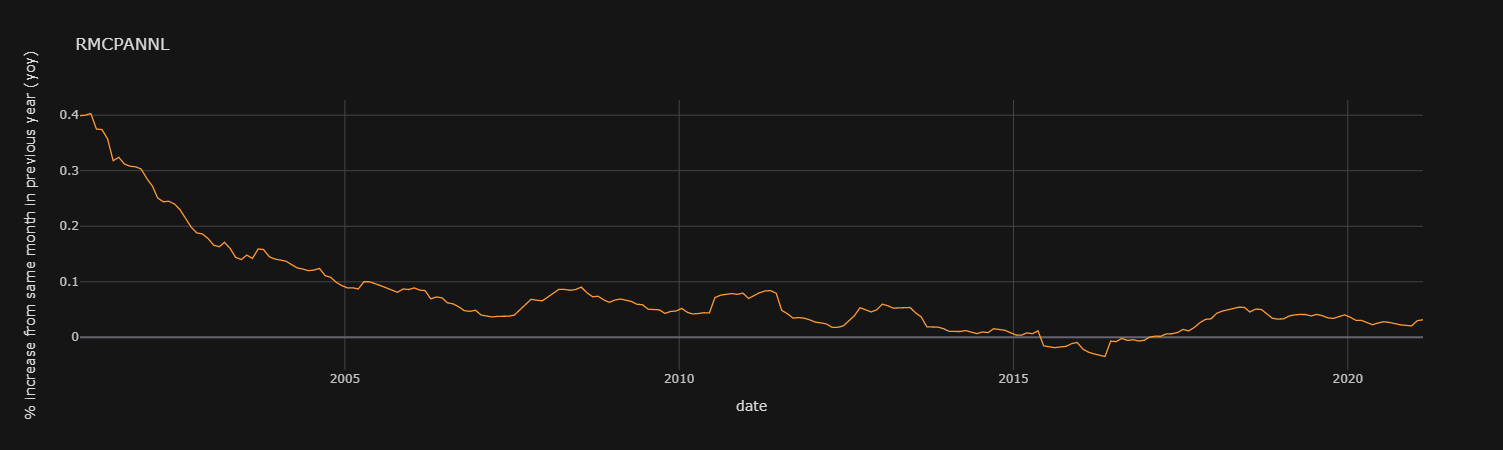

In [25]:
df["RMCPANNL"]["yoy"].iplot(theme = "solar", title = "RMCPANNL", xTitle = "date",
                            yTitle = "% increase from same month in previous year (yoy)")

RMCPANNL's 1st difference (1d) does look rather stationary:

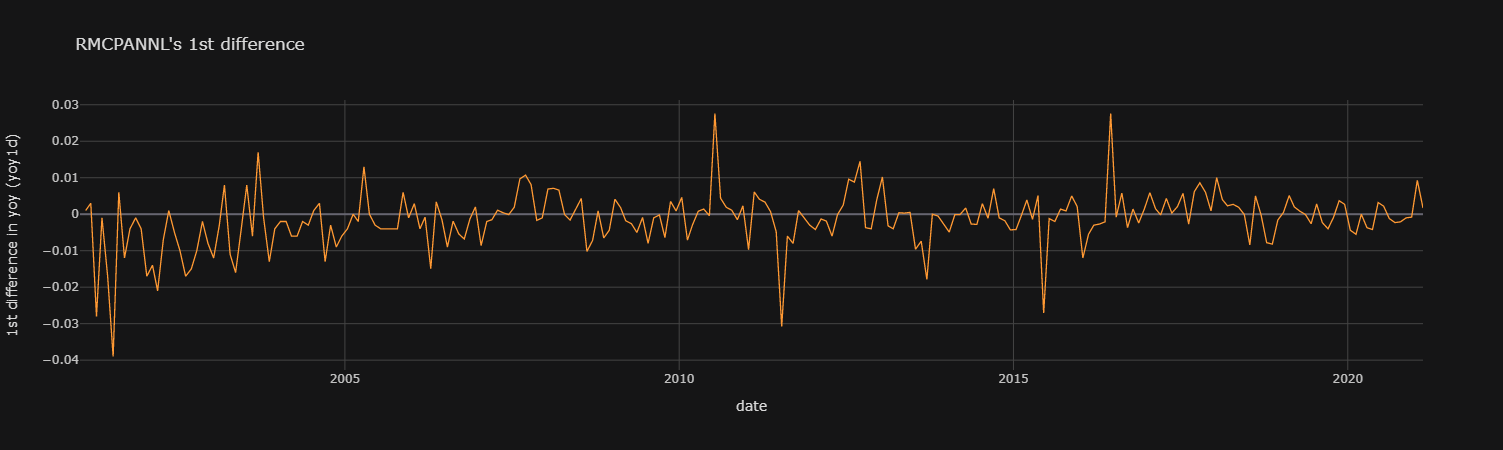

In [26]:
df["RMCPANNL"]["yoy"].diff(1).iplot(theme = "solar",
                                    title = "RMCPANNL's 1st difference",
                                    xTitle = "date",
                                    yTitle = "1st difference in yoy (yoy1d)")

Upon quick graphical visualisation, it seems as though we ought to choose RMCPANNL's 1st difference

### Checking For Stationarity Via Test Statistics <a class="anchor" id="checkingforstationarityviateststatistics"></a>

We can create a Python function for the three aforementioned test-statistics for stationarity: Augmented Dickey-Fuller (ADF), Phillips-Perron (PP) and the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) ones.

For the ADF test, one may use the ```adfuller``` function from the ```statsmodels``` library (imported via the line ```from statsmodels.tsa.stattools import adfuller```), but that library doesn't have functions for all the tests in question. the ```arch``` library does - however. So I will define a Python function ```Stationarity_Table``` returning all relevant arch stationarity results of interest:

In [27]:
import arch
from arch.unitroot import ADF, PhillipsPerron, KPSS
print(arch.__version__)

4.19


In [28]:
def Stationarity_Table(data = [df["RMCPANNL"]["yoy"].dropna(),
                               df["RMUNPTOTP"]["raw"].dropna()],
                       dataset_names = ["RMCPANNL", "RMUNPTOTP"],
                       tests = ["ADF", "PP", "KPSS"],
                       enumerate_data = False):
    """Stationarity_Table Version 1.0:
    This function returns a Pandas data-frame with the results of the
    Augmented Dickey-Fuller (ADF), Phillips-Perron (PP) and the
    Kwiatkowski–Phillips–Schmidt–Shin (KPSS) stationarity tests from
    the arch library.
    
    
    Parameters:
    ----------
    
    data: list
        list of nan-less Pandas data-frames of number-series on which the test will be performed
        Default: data = [df["RMCPANNL"]["yoy"].dropna(), df["RMUNPTOTP"]["raw"].dropna()]
    
    dataset_names: list
        List of strings of the names to show as columns in our resulted table
        Default: dataset_names = ["RMCPANNL", "RMUNPTOTP"]
    
    tests: list
        List of strings of the stationarity tests wished.
        You may choose between "ADF", "PP", and/or "KPSS".
        Default: tests = ["ADF", "PP", "KPSS"]
    
    
    Dependencies:
    ----------
    
    pandas 1.2.3
    numpy 1.19.5
    arch 4.15 as ' from arch.unitroot import ADF, PhillipsPerron, KPSS '
    
    
    Examples:
    --------
    
    >>> import DatastreamDSWS as dsws
    >>> ds = dsws.Datastream(username = "insert dsws username here", password = "insert dsws password here")
    >>> 
    >>> df_1 = ds.get_data(tickers = "RMCPANNL,RMUNPTOTP", # be carefulnot to put spaces in between elements here, or else these spaces will be included in column names.
    >>>                    fields = "X", start = '2000-01-01', freq = 'M')
    >>> 
    >>> Stationarity_Table(data = [df_1["RMCPANNL"]["X"].dropna(), df_1["RMUNPTOTP"]["X"].dropna()], dataset_names = ["RMCPANNL", "RMUNPTOTP"], tests = ["ADF", "PP", "KPSS"], enumerate_data = False)
    """
    
    _columns, stationarity_test = [], []
    for i in tests:
        _columns.append((i, "Test-statistic", "")) # The ', ""' is there for the Pandas MultiIndex
        _columns.append((i, "p-value", ""))
        _columns.append((i, "Number of lags used", ""))
        _columns.append(
            (i,
             "Number of observations used for the regression and critical values'calculation",
             ""))
        _columns.append((i, "Critical values", '1%'))
        _columns.append((i, "Critical values", '5%'))
        _columns.append((i, "Critical values", '10%'))
        _columns.append((i, "Null hypothesis", ""))
    
    for d, _d in zip([D.astype(np.float64) for D in data], enumerate(data)):
        
        if enumerate_data == True:
            print(_d[0])
        
        _tests, _data = [], []
        if "ADF" in tests: _tests.append(ADF(d))
        if "PP" in tests: _tests.append(PhillipsPerron(d))
        if "KPSS" in tests: _tests.append(KPSS(d))
        
        for i in _tests:
            _data.append(i.stat)
            _data.append(i.pvalue)
            _data.append(i.lags)
            _data.append(i.nobs)
            for k in [i.critical_values[j] for j in i.critical_values]:
                _data.append(k)
            _data.append(i.null_hypothesis)
        
        stationarity_test.append(
            pd.DataFrame(
                data = np.array(_data)[np.newaxis],
                columns = pd.MultiIndex.from_tuples(_columns)).T)
    
    stationarity_test_table = pd.concat(
        stationarity_test, axis = 1, join = "inner")
    
    stationarity_test_table = pd.DataFrame(
        data = stationarity_test_table.values,
        index = stationarity_test_table.index,
        columns = dataset_names)
    
    return stationarity_test_table

In [29]:
Stationarity_Table(
    data =  [df["RMCPANNL"]["yoy"].dropna(),
             df["RMUNPTOTP"]["raw"].dropna(),
             df["RMUNPTOTP"]["yoy"].dropna(),
             df["RMXRUSD."]["raw"].dropna(),
             df["RMXRUSD."]["yoy"].dropna(),
             df["RMXREUR."]["raw"].dropna(),
             df["RMXREUR."]["yoy"].dropna(),
             df["RMGOVBALA"]["raw"].dropna(),
             df["RMGOVBALA"]["yoy"].dropna(),
             df["CLc1"]["Close Price 30D Moving Average"].dropna(),
             df["CLc1"]["yoy"].dropna()],
    dataset_names = ["RMCPANNL yoy",
                     "RMUNPTOTP raw","RMUNPTOTP yoy",
                     "RMXRUSD. raw", "RMXRUSD. yoy",
                     "RMXREUR. raw", "RMXREUR. yoy",
                     "RMGOVBALA raw", "RMGOVBALA yoy",
                     "CLc1 Close Price 30D Moving Average",
                     "CLc1 Close Price yoy"],
    tests = ["ADF", "PP", "KPSS"],
    enumerate_data = False)
# # for ' data ', one could use:
# [df[i][j].dropna() for i,j in zip(
#     ["RMCPANNL", "RMUNPTOTP", "RMUNPTOTP",
#      "RMXRUSD.", "RMXRUSD.", "RMXREUR.", "RMXREUR.",
#      "RMGOVBALA", "RMGOVBALA", "CLc1", "CLc1"],
#     ["yoy", "raw", "yoy", "raw", "yoy", "raw", "yoy",
#      "raw", "yoy", "Close Price 30D Moving Average", "yoy"])]

RMCPANNL yoy  \
ADF  Test-statistic                                                         -4.051553792556906   
     p-value                                                              0.001163361637386088   
     Number of lags used                                                                    15   
     Number of observations used for the regression ...                                    226   
     Critical values                                    1%                 -3.4596204846395824   
                                                        5%                 -2.8744153028455948   
                                                        10%                -2.5736320761218576   
     Null hypothesis                                         The process contains a unit root.   
PP   Test-statistic                                                         -6.222570155251549   
     p-value                                                             5.180442941450411e-08   
     Number of lags used                                                                    15   
     Number of observations used for the regression ...                                    241   
     Critical values                                    1%                 -3.4577787098622674   
                                                        5%                  -2.873608704758507   
                                                        10%                 -2.573201765981991   
     Null hypothesis                                         The process contains a unit root.   
KPSS Test-statistic                                                         1.4800731071716948   
     p-value                                                            0.00019023844456606865   
     Number of lags used                                                                    10   
     Number of observations used for the regression ...                                    242   
     Critical values                                    1%                              0.7428   
                                                        5%                              0.4614   
                                                        10%                             0.3475   
     Null hypothesis                                         The process is weakly stationary.   

                                                                                 RMUNPTOTP raw  \
ADF  Test-statistic                                                        -2.2358868252128143   
     p-value                                                               0.19347930391915463   
     Number of lags used                                                                    15   
     Number of observations used for the regression ...                                    226   
     Critical values                                    1%                 -3.4596204846395824   
                                                        5%                 -2.8744153028455948   
                                                        10%                -2.5736320761218576   
     Null hypothesis                                         The process contains a unit root.   
PP   Test-statistic                                                         -2.636782536007914   
     p-value                                                               0.08563082837097685   
     Number of lags used                                                                    15   
     Number of observations used for the regression ...                                    241   
     Critical values                                    1%                 -3.4577787098622674   
                                                        5%                  -2.873608704758507   
                                                        10%                 -2.573201765981991   
     Null hypothesis                                         Th

> **Interpreting the stationarity table**: <a class="anchor" id="Interpretingthestationaritytable"></a>
> As per the above, the null hypothesis of the ADF is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above a critical size, then we cannot reject that there is a unit root. If the process has a unit root, then it is a non-stationary time series. If the p-value is close to significant, then the critical values should be used to judge whether to reject the null.

Since ${ADF}_{{Test-statistic}_{RMCPANNL yoy}} \approx -6.025 < {ADF}_{{1\% Critical value}_{RMCPANNL yoy}} \approx -3.471$, we can reject the hypothesis that there is a unit root and presume our series to be stationary. Same conclusions can be taken from the PP and KPSS tests of our RMCPANNL data. This is an interesting finding since our graphical analysis suggested otherwise.

Nonetheless, analysing the table's figures for RMUNPTOTP, RMXRUSD, RMXREUR, and RMGOVBALA shows us that they're non-stationary (for the most part - especially with the ADF test). We ought to difference them once and see if they are stationary then.

### Differencing <a class="anchor" id="differencing"></a>

As aforementioned, differencing a time series $\{z\}_1^T$ once would render $\{z_2 - z_1, z_3 - z_2, ..., z_T - z_{T-1}\}$. Let's add the 1st difference of our data to our Pandas data-frame ```df```:

In [30]:
df["RMCPANNL", "yoy1d"] = df["RMCPANNL"]["yoy"].diff(1)
df["RMUNPTOTP", "yoy1d"] = df["RMUNPTOTP"]["yoy"].diff(1)
df["RMXRUSD.", "yoy1d"] = df["RMXRUSD."]["yoy"].diff(1)
df["RMXRUSD.", "yoy1d"] = df["RMXRUSD."]["yoy"].diff(1)
df["RMXREUR.", "yoy1d"] = df["RMXREUR."]["yoy"].diff(1)
df["RMGOVBALA", "yoy1d"] = df["RMGOVBALA"]["yoy"].diff(1)
df["CLc1", "yoy1d"] = df["CLc1"]["yoy"].diff(1)
df = df.sort_index(axis = 1)

In [31]:
df.dropna()

Instrument        CLc1                                                     \
Field      Close Price Close Price 30D Moving Average       yoy     yoy1d   
2001-02-15        28.8                      29.811333  0.078155 -0.021658   
2001-03-15       26.58                         28.976 -0.042306 -0.120460   
2001-04-15        28.2                          27.25 -0.031823  0.010483   
2001-05-15       28.98                      27.932667  0.057495  0.089317   
2001-06-15       28.53                      28.617667 -0.040298 -0.097793   
...                ...                            ...       ...       ...   
2020-10-15       40.92                      39.479333 -0.290909 -0.037946   
2020-11-15       40.12                      39.577333 -0.283577  0.007332   
2020-12-15       47.59                         43.203 -0.248931  0.034647   
2021-01-15       52.04                      48.701333 -0.189239  0.059692   
2021-02-15       59.73                         53.606 -0.028114  0.161125   

Instrument RMCPANNL         RMGOVBALA                     RMUNPTOTP            \
Field           yoy   yoy1d       raw       yoy     yoy1d       raw       yoy   
2001-02-15   0.4000  0.0010    -601.2  0.301580 -0.578641    1032.3 -0.137306   
2001-03-15   0.4030  0.0030    -865.2  0.047458 -0.254123     992.8 -0.149053   
2001-04-15   0.3750 -0.0280   -1087.5 -0.101908 -0.149365     948.4 -0.167486   
2001-05-15   0.3740 -0.0010   -1404.5  0.026831  0.128739     890.8 -0.188263   
2001-06-15   0.3570 -0.0170   -2268.9  0.259730  0.232899     840.3 -0.212465   
...             ...     ...       ...       ...       ...       ...       ...   
2020-10-15   0.0224 -0.0021  -76512.0  1.815788 -0.003413     285.7  0.104368   
2020-11-15   0.0214 -0.0010  -85981.9  1.474314 -0.341474     290.7  0.120663   
2020-12-15   0.0206 -0.0008 -105906.6  1.202753 -0.271561     296.1  0.148119   
2021-01-15   0.0299  0.0093    -112.3 -0.842607 -2.045360     292.2  0.128621   
2021-02-15   0.0316  0.0017   -8430.8 -0.198989  0.643618     293.5  0.143358   

Instrument           RMXREUR.                     RMXRUSD.                      
Field          yoy1d      raw       yoy     yoy1d      raw       yoy     yoy1d  
2001-02-15 -0.016370   2.4729  0.342435  0.019941     2.68  0.433155  0.009242  
2001-03-15 -0.011747   2.4849  0.340436 -0.001999     2.73  0.421875 -0.011280  
2001-04-15 -0.018433   2.4880  0.329557 -0.010879     2.79  0.409091 -0.012784  
2001-05-15 -0.020777   2.4910  0.345977  0.016420     2.85  0.397059 -0.012032  
2001-06-15 -0.024202   2.4732  0.238458 -0.107520     2.90  0.380952 -0.016106  
...              ...      ...       ...       ...      ...       ...       ...  
2020-10-15  0.009587   4.8733  0.025138 -0.000403     4.14 -0.037209  0.004651  
2020-11-15  0.016295   4.8699  0.021307 -0.003830     4.12 -0.044084 -0.006874  
2020-12-15  0.027456   4.8707  0.019551 -0.001757     4.00 -0.069767 -0.025684  
2021-01-15 -0.019498   4.8728  0.019734  0.000183     4.00 -0.071926 -0.002158  
2021-02-15  0.014737   4.8741  0.019089 -0.000645     4.03 -0.079909 -0.007983  

[241 rows x 18 columns]

In [32]:
Stationarity_Table(
    data = [
        df[i]["yoy1d"].dropna()
        for i in [
            "RMCPANNL", "RMUNPTOTP", "RMXRUSD.",
            "RMXREUR.", "RMGOVBALA", "CLc1"]],
    dataset_names = [
        "RMCPANNL yoy1d", "RMUNPTOTP yoy1d",
        "RMXRUSD. yoy1d", "RMXREUR. yoy1d",
        "RMGOVBALA yoy1d", "CLc1 Close Price yoy1d"],
    tests = ["ADF", "PP"])

RMCPANNL yoy1d  \
ADF Test-statistic                                                         -3.977860518435553   
    p-value                                                             0.0015309816242762859   
    Number of lags used                                                                    14   
    Number of observations used for the regression ...                                    226   
    Critical values                                    1%                 -3.4596204846395824   
                                                       5%                 -2.8744153028455948   
                                                       10%                -2.5736320761218576   
    Null hypothesis                                         The process contains a unit root.   
PP  Test-statistic                                                         -13.79074025256595   
    p-value                                                             8.936209409564236e-26   
    Number of lags used                                                                    15   
    Number of observations used for the regression ...                                    240   
    Critical values                                    1%                 -3.4578942529658563   
                                                       5%                 -2.8736593200231484   
                                                       10%                 -2.573228767361111   
    Null hypothesis                                         The process contains a unit root.   

                                                                              RMUNPTOTP yoy1d  \
ADF Test-statistic                                                         -5.125109104456339   
    p-value                                                            1.2477556762161869e-05   
    Number of lags used                                                                    12   
    Number of observations used for the regression ...                                    228   
    Critical values                                    1%                 -3.4593607492757554   
                                                       5%                 -2.8743015807562924   
                                                       10%                -2.5735714042782396   
    Null hypothesis                                         The process contains a unit root.   
PP  Test-statistic                                                           -9.5568680055942   
    p-value                                                            2.4854097675696995e-16   
    Number of lags used                                                                    15   
    Number of observations used for the regression ...                                    240   
    Critical values                                    1%                 -3.4578942529658563   
                                                       5%                 -2.8736593200231484   
                                                       10%                 -2.573228767361111   
    Null hypothesis                                         The process contains a unit root.   

                                                                               RMXRUSD. yoy1d  \
ADF Test-statistic                                                          -5.82717488801751   
    p-value                                                            4.0537140393384894e-07   
    Number of lags used                                                                    12   
    Number of observations used for the regression ...                                    228   
    Critical values                                    1%                 -3.4593607492757554   
                                                       5%                 -2.8743015807562924   
                                                       10%                -2.5735714042782396   
   

Now they're all stationary. We ought to use datasets treated similarly for consistency (*e.g.*: compare 'RMCPANNL yoy1d' with 'RMUNPTOTP yoy1d' rather than with 'RMUNPTOTP yoy'), so we will use the ones shown in the last table (*i.e.*: 'yoy1d' datasets).

*N.B.*: The RMGOVBALA yoy1d dataset is causing issues with the KPSS test, but that one is only for weak stationarity, and is not of as much interest to us in our study - I just wanted to include it to portray the extend of the ```Stationarity_Table``` function. The RMGOVBALA yoy1d dataset is causing issues with the KPSS test because of its large variance, as can be seen in this graph:

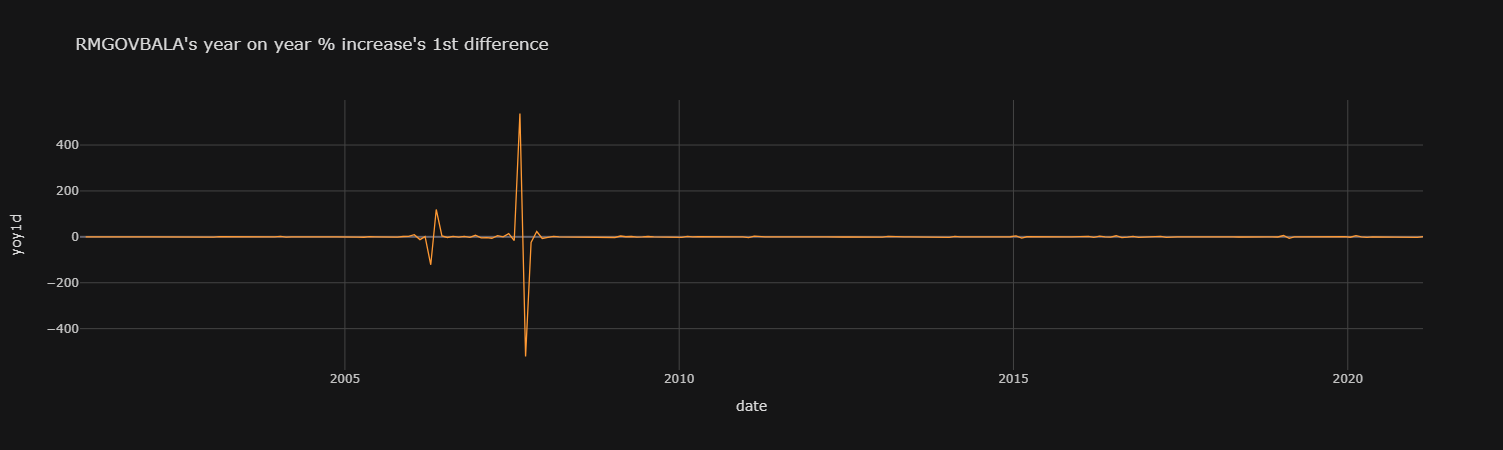

In [33]:
df["RMGOVBALA"]["yoy1d"].iplot(
    theme = "solar", xTitle = "date", yTitle = "yoy1d",
    title = "RMGOVBALA's year on year % increase's 1st difference")

## Modelling <a class="anchor" id="modelling"></a>

Now we will look at which ARMA-family model to implement. We'll look at the best model orders to choose before ([*ex-ante*](https://www.investopedia.com/terms/e/exante.asp)) and after ([*ex-post*](https://www.investopedia.com/terms/e/expost.asp)) going through modelling procedures.

### [Ex-Ante](https://www.investopedia.com/terms/e/exante.asp) Parameter Identification: Autocorrelation and Partial Autocorrelation Functions <a class="anchor" id="exanteparameteridentification"></a>

To figure out our parameter identification (*i.e.*: what lags to use in our model), we may want to plot [ACF](https://www.investopedia.com/terms/a/autocorrelation.asp) and [PACF](https://en.wikipedia.org/wiki/Partial_autocorrelation_function) diagrams:

In [34]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

N.B.: the [semicolon](https://github.com/statsmodels/statsmodels/issues/4155) at the end of the code for our plots below is there to avoid [duplicates](https://github.com/statsmodels/statsmodels/issues/1265).

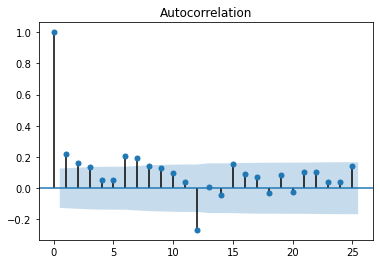

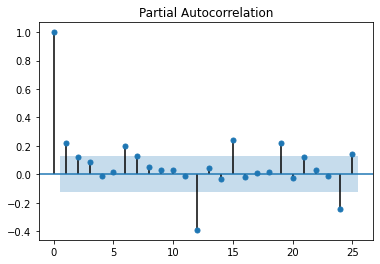

In [35]:
sm.graphics.tsa.plot_acf(x = df["RMCPANNL"]["yoy1d"].dropna(), lags = 25);
sm.graphics.tsa.plot_pacf(x = df["RMCPANNL"]["yoy1d"].dropna(), lags = 25);

From these graphs (also known as (a.k.a.): correlograms), we could identify an AR(1,4,5) (non-consecutive) model; but the MA part is harder to decipher. Let's have a look at how those models would fair:
* 1st: a simple ARMA(5,2) model (*i.e.*: a SARIMA(5,0,2) model), then
* 2nd: a SARIMA(5,0,2)(1, 0, 0)12 model:

#### ARMA(5,2) <a class="anchor" id="ARMA52"></a>

In [36]:
from statsmodels.tsa.arima.model import ARIMA

In [37]:
arima502c = ARIMA(endog = np.array(df["RMCPANNL"]["yoy1d"].dropna()),
                  order = (5, 0, 2), # We don't need to difference our data again, so 'd' is set to 0.
                  trend = "c")
arima502c_fit = arima502c.fit()

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [38]:
arima502c_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  241
Model:                 ARIMA(5, 0, 2)   Log Likelihood                 847.684
Date:                Mon, 19 Apr 2021   AIC                          -1677.368
Time:                        14:33:02   BIC                          -1646.005
Sample:                             0   HQIC                         -1664.733
                                - 241                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.913      0.056      -0.003    3.66e-05
ar.L1          0.0858     17.280      0.005      0.996     -33.783      33.955
ar.L2          0.0603      8.153      0.007      0.994     -15.919      16.039
ar.L3          0.1161      1.110      0.105      0.917      -2.059       2.292
ar.L4         -0.0028      1.219     -0.002      0.998      -2.393       2.387
ar.L5         -0.0027      0.782     -0.003      0.997      -1.535       1.530
ma.L1          0.0995     17.281      0.006      0.995     -33.770      33.969
ma.L2          0.0615      5.295      0.012      0.991     -10.317      10.440
sigma2      5.154e-05    3.3e-06     15.595      0.000    4.51e-05     5.8e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               274.28
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.60
Prob(H) (two-sided):                  0.01   Kurtosis:                         8.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### SARIMA(5,0,2)(1, 0, 0)12  <a class="anchor" id="SARIMA50210012"></a>

In [39]:
df

Instrument        CLc1                                                     \
Field      Close Price Close Price 30D Moving Average       yoy     yoy1d   
2001-01-15       30.05                         28.535  0.099812       NaN   
2001-02-15        28.8                      29.811333  0.078155 -0.021658   
2001-03-15       26.58                         28.976 -0.042306 -0.120460   
2001-04-15        28.2                          27.25 -0.031823  0.010483   
2001-05-15       28.98                      27.932667  0.057495  0.089317   
...                ...                            ...       ...       ...   
2020-10-15       40.92                      39.479333 -0.290909 -0.037946   
2020-11-15       40.12                      39.577333 -0.283577  0.007332   
2020-12-15       47.59                         43.203 -0.248931  0.034647   
2021-01-15       52.04                      48.701333 -0.189239  0.059692   
2021-02-15       59.73                         53.606 -0.028114  0.161125   

Instrument RMCPANNL         RMGOVBALA                     RMUNPTOTP            \
Field           yoy   yoy1d       raw       yoy     yoy1d       raw       yoy   
2001-01-15   0.3990     NaN    -306.1  0.880221       NaN    1032.9 -0.120936   
2001-02-15   0.4000  0.0010    -601.2  0.301580 -0.578641    1032.3 -0.137306   
2001-03-15   0.4030  0.0030    -865.2  0.047458 -0.254123     992.8 -0.149053   
2001-04-15   0.3750 -0.0280   -1087.5 -0.101908 -0.149365     948.4 -0.167486   
2001-05-15   0.3740 -0.0010   -1404.5  0.026831  0.128739     890.8 -0.188263   
...             ...     ...       ...       ...       ...       ...       ...   
2020-10-15   0.0224 -0.0021  -76512.0  1.815788 -0.003413     285.7  0.104368   
2020-11-15   0.0214 -0.0010  -85981.9  1.474314 -0.341474     290.7  0.120663   
2020-12-15   0.0206 -0.0008 -105906.6  1.202753 -0.271561     296.1  0.148119   
2021-01-15   0.0299  0.0093    -112.3 -0.842607 -2.045360     292.2  0.128621   
2021-02-15   0.0316  0.0017   -8430.8 -0.198989  0.643618     293.5  0.143358   

Instrument           RMXREUR.                     RMXRUSD.                      
Field          yoy1d      raw       yoy     yoy1d      raw       yoy     yoy1d  
2001-01-15       NaN   2.4646  0.322494       NaN     2.62  0.423913       NaN  
2001-02-15 -0.016370   2.4729  0.342435  0.019941     2.68  0.433155  0.009242  
2001-03-15 -0.011747   2.4849  0.340436 -0.001999     2.73  0.421875 -0.011280  
2001-04-15 -0.018433   2.4880  0.329557 -0.010879     2.79  0.409091 -0.012784  
2001-05-15 -0.020777   2.4910  0.345977  0.016420     2.85  0.397059 -0.012032  
...              ...      ...       ...       ...      ...       ...       ...  
2020-10-15  0.009587   4.8733  0.025138 -0.000403     4.14 -0.037209  0.004651  
2020-11-15  0.016295   4.8699  0.021307 -0.003830     4.12 -0.044084 -0.006874  
2020-12-15  0.027456   4.8707  0.019551 -0.001757     4.00 -0.069767 -0.025684  
2021-01-15 -0.019498   4.8728  0.019734  0.000183     4.00 -0.071926 -0.002158  
2021-02-15  0.014737   4.8741  0.019089 -0.000645     4.03 -0.079909 -0.007983  

[242 rows x 18 columns]

In [40]:
s1arima502c = ARIMA(endog = np.array(df["RMCPANNL"]["yoy1d"].dropna()),
                    order = (5, 0, 2),
                    trend = "c",
                    seasonal_order = (1, 0, 0, 12))
s1arima502c_fit = s1arima502c.fit()

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

c:\users\u6082174.ten\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [41]:
s1arima502c_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  241
Model:             ARIMA(5, 0, 2)x(1, 0, [], 12)   Log Likelihood                 868.387
Date:                           Mon, 19 Apr 2021   AIC                          -1716.774
Time:                                   14:33:04   BIC                          -1681.926
Sample:                                        0   HQIC                         -1702.735
                                           - 241                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.001     -1.856      0.063      -0.003    8.27e-05
ar.L1          0.0761      2.209      0.034      0.973      -4.253       4.405
ar.L2          0.0641      1.920      0.033      0.973      -3.698       3.827
ar.L3          0.2522      0.310      0.815      0.415      -0.355       0.859
ar.L4          0.0520      0.474      0.110      0.913      -0.877       0.981
ar.L5          0.0496      0.366      0.136      0.892      -0.667       0.766
ma.L1          0.1203      2.203      0.055      0.956      -4.198       4.439
ma.L2          0.0607      1.679      0.036      0.971      -3.231       3.352
ar.S.L12      -0.4396      0.042    -10.401      0.000      -0.522      -0.357
sigma2      4.289e-05   2.85e-06     15.025      0.000    3.73e-05    4.85e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               142.78
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -0.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### [Ex-Post](https://www.investopedia.com/terms/e/expost.asp) Parameter Identification: Information Criteria and Mean of Absolute & squared Errors <a class="anchor" id="expostparameteridentification"></a>

#### Graphical Analysis <a class="anchor" id="graphicalanalysis"></a>

After having fit a model, one may try to look at the residuals to compare models:

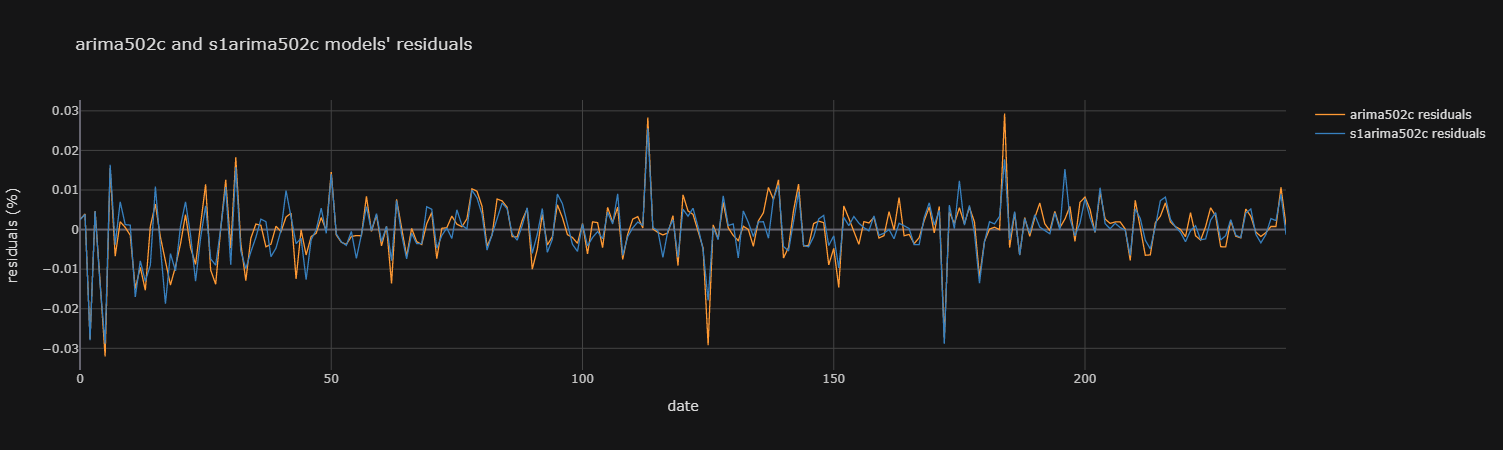

In [42]:
models_resid = pd.DataFrame(
    data = {'arima502c residuals' : arima502c_fit.resid,
            's1arima502c residuals' : s1arima502c_fit.resid})
models_resid.iplot(
    theme = "solar", xTitle = "date",
    yTitle = "residuals (%)",
    title = "arima502c and s1arima502c models' residuals")

Looking at such graphical information is not simple. (i) Not only is it arbitrary to chose a model over another from graphical information (ii) it quickly becomes difficult when comparing many models together. That's why we may compare them instead with performance measurements such as [Information Criteria](https://en.wikipedia.org/wiki/Model_selection#Criteria):

#### Information Criteria <a class="anchor" id="informationcriteria"></a>

In [43]:
def IC_Table(models_fit, models_name):
    return pd.DataFrame(
        data = [[i.aic, i.aicc, i.bic, i.hqic]
                for i in models_fit],
        columns = ['AIC', 'AICC', 'BIC', 'HQIC'],
        index = [str(i) for i in models_name])

In [44]:
# ' ic ' standing for 'information criteria':
ic0 = IC_Table(models_fit = [arima502c_fit, s1arima502c_fit],
                 models_name = ['arima502c', 's1arima502c'])

In [45]:
ic0

AIC         AICC          BIC         HQIC
arima502c   -1677.368373 -1676.589152 -1646.005200 -1664.732731
s1arima502c -1716.774385 -1715.817863 -1681.926416 -1702.734784

We can similarly go through each permutation within limits of our SARIMA model's parameters, and go beyond just recording IC information - including [mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) ([MSE](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.mse.html#statsmodels.tsa.arima.model.ARIMAResults.mse)) and [sum of squared error](https://en.wikipedia.org/wiki/Residual_sum_of_squares) ([SSE](https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.sse.html#statsmodels.tsa.arima.model.ARIMAResults.sse), a.k.a.: RSS) information too.

#### Mean Squared Errors and Sum of squared Errors <a class="anchor" id="meansquarederrorsandsumofsquarederrors"></a>

We can define the below function to return a table of

* the Akaike information criterion (AIC),
* the AICc (AIC with a correction for small sample sizes),
* the Bayesian information criterion (BIC) (aka Schwarz criterion (also SBC, SBIC)) and
* the Hannan-Quinn information criterion (HQC) as well as
* the Mean Squared Errors (MSE) and
* the Sum of Squared Errors (SSE) (aka: residual sum of squares (RSS))

of any specified ARIMAX model, and then choose the one providing the lowest (of any one chosen error measure above) as the optimal model of choice:

In [46]:
import itertools # We need this library to iteratethrough each permutation of exogenous variable possible

***N.B.***: Note that we need to lag our exogenous variables since we are putting ourselves in the shoes of a programmer who is using past values to predict tomorrow's.

In [47]:
def Reg_Perm_Table(endog = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist()), # the ' [1:] ' is here to get same number of figures as in our exogenous variables.
                   exogenous = [df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist() # ' .shift(1) ' is here to get lagged values; the ' [1:] ' is there to remove the 0th value which is nan due to the lagging.
                                for i in ["CLc1", "RMGOVBALA", "RMUNPTOTP", "RMXREUR.", "RMXRUSD."]],
                   exogenous_names = ["CLc1", "RMGOVBALA", "RMUNPTOTP", "RMXREUR.", "RMXRUSD."],
                   d = [0], D = [0], s = [12],
                   p = range(5), q = range(5),
                   P = range(5), Q = range(5),
                   trend = "c",
                   print_progress = False,
                   try_loop = False,
                   save_model_fit = False,
                   lowest_no = 3):
    """ Reg_Perm_Table Version 1.0:
    This Python function ' Reg_Perm_Table ' goes through each permutation of possible ARIMA orders
    (chosen in parameters d, D, s, p, P, q, and Q) and exogenous variables and returns two Pandas
    data-frames (table and lowest) to help decide (i) the optimal exogenous variables to use,
    (ii) the optimal order of our ARIMA model to use.
    ' table ' consists of the Akaike information criterion (AIC),
    the AICc (AIC with a correction for small sample sizes),
    the Bayesian information criterion (BIC) (aka Schwarz criterion (also SBC, SBIC)) and
    the Hannan-Quinn information criterion (HQC)
    as well as the Mean Squared Errors (MSE) and
    the Sum of Squared Errors (SSE) (aka: residual sum of squares (RSS)) of any specified ARIMAX model.
    ' lowest ' consists of the name of all models with lowest values of all the metrics in ' table '.
    
    For more information on ARIMA orders (both (i) orders p, d, and q and (ii) seasonal orders P, D,
    Q and s), look at the statsmodels website:
    https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
    
    
    Parameters:
    ----------
    
    endog: Numpy array
        Numpy array of a list of values used as endogenous variables in our ARIMAX model.
        Defaulted to: np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist()) # The ' [1:] ' is here to get same number of figures as in our exogenous variables.
    
    exogenous: list
        List of lists of each of the exogenous variables wished. can be set to ' None ' BUT
        IT CANNOT CONSIST OF ONLY ONE ELEMENT.
        Defaulted to: exogenous = [df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist() for i in ["CLc1", "RMGOVBALA", "RMUNPTOTP", "RMXREUR.", "RMXRUSD."]] # ' .shift(1) ' is here to get lagged values; the ' [1:] ' is there to remove the 0th value which is nan due to the lagging.
    
    exogenous_names: list
        list of strings of the names of the exogenous variables wished to be seen in
        the outputed data-frames. They have to be in the same order as in the ' exogenous ' variables.
        Defaulted to: exogenous_names = ["CLc1", "RMGOVBALA", "RMUNPTOTP", "RMXREUR.", "RMXRUSD."]
    
    p: list
        list of the ARIMA order 'p' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: p = [0]
    
    d: list
        list of the ARIMA order 'd' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: d = [0]
    
    q: list
        list of the ARIMA order 'q' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: q = [0]
    
    P: list
        list of the ARIMA seasonal order 'P' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: P = [0]
    
    D: list
        list of the ARIMA seasonal order 'D' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: D = [0]
    
    Q: list
        list of the ARIMA seasonal order 'Q' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: Q = [0]
    
    s: list
        list of the ARIMA seasonal order 's' that the user wishes to iteratethrough. This can be a range.
        Defaulted to: s = [0]
    
    trend: str
        str{‘n’,’c’,’t’,’ct’} or 'iterate-able', optional as per statsmodels.tsa.arima.model.ARIMA.
        Defaulted to: trend = "c"
    
    print_progress: Boolean
        If True, then a summary of each fitted model will appear in order of execution.
        Defaulted to: print_progress = False
    
    try_loop: Boolean
        If true, a try and except (then pass) loop is used over the model specification and
        fitting. If that part of the code fails, it will just ignore the model that caused an error from the output.
        Defaulted to: try_loop = False
    
    save_model_fit: Boolean
        ARIMA model fit's Python objects take up a lot of memory, so they are not saved. If
        this argument is st to True, our function then returns a new list full of each fit objects in the order they
        were executed called ' model_fit_list '; the function returns: table, model_fit_list, lowest
        Defaulted to: save_model_fit = False
    
    lowest_no: int
        the returned table ' lowest ' provides the name of each model with lowest AIC, AICC, BIC,
        HQIC, MSE and SSE up to the 3rd lowest value by default, but you can change that here.
        Defaulted to: lowest_no = 3
    
    
    Dependencies:
    ----------
    
    itertools
    numpy as np: version 1.19.5
    pandas as pd: version 1.2.3
    from statsmodels.tsa.arima.model import ARIMA: version 0.11.1
    
    
    Examples:
    --------
    
    >>> import DatastreamDSWS as dsws # Using LSEG Refinitiv's Datastream Python API named DataStreem Web Service (DSWS).
    >>> ds = dsws.Datastream(username = "insert dsws username here", password = "insert dsws password here")
    >>> 
    >>> df_1 = ds.get_data(tickers = "RMCPANNL,RMGOVBALA,RMXRUSD.", # be carefulnot to put spaces in between elements here, or else these spaces will be included in column names.
    >>>                    fields = "X", start = '2000-01-01', freq = 'M')
    >>> 
    >>> Reg_Perm_Table(endog = np.array(df_1.dropna()["RMCPANNL"]["X"][1:].values.tolist()), # the ' [1:] ' is here to get same number of figures as in our exogenous variables.
    >>>                exogenous = [df_1.dropna()[i]["X"].shift(1)[1:].values.tolist() # ' .shift(1) ' is here to get lagged values; the ' [1:] ' is there to remove the 0th value which is nan due to the lagging.
    >>>                             for i in ["RMXRUSD.", "RMGOVBALA"]],
    >>>                exogenous_names = ["RMXRUSD.", "RMGOVBALA"])
    """
    
    model_table_data, model_fit_list, models_name_list = [], [], [] # Lists to be appended.
    
    for _p in p: # Going through each permutation of possible arguments.
        for _d in d:
            for _q in q:
                for _P in P:
                    for _D in D:
                        for _Q in Q:
                            for _s in s:
                                
                                def Modelling(exog1, endog1 = endog,
                                              order1 = (_p, _d, _q), trend1 = trend,
                                              seasonal_order1 = (_P, _D, _Q, _s)):
                                    # global?
                                    return ARIMA(endog = endog1, exog = exog1,
                                                 order = order1, trend = trend1,
                                                 seasonal_order = (_P, _D, _Q, _s)).fit()
                                if exogenous != None:
                                    for j in range(1,len(exogenous_names)+1):
                                        for i,i_name in zip(itertools.combinations(exogenous, r = j),
                                                            itertools.combinations(exogenous_names, r = j)):
                                            
                                            if try_loop == True:
                                                try: # statsmodels' ARIMA function does not work 100% of the time.
                                                    model = Modelling(exog1 = np.array(i).T)
                                                    model_table_data.append(
                                                        [model.aic, model.aicc, model.bic,
                                                         model.hqic, model.mse, model.sse])
                                                    if save_model_fit == True: model_fit_list.append(model)
                                                    models_name_list.append(
                                                        f"sarima{_p},{_d},{_q},{_P},{_D},{_Q},{_s},{trend},exo={i_name}")
                                                    if print_progress == True: # For debugging.
                                                        print(models_name_list[-1])
                                                        display(model_fit_list[-1].summary())
                                                except:
                                                    pass
                                            else: # i.e.: if try_loop != True
                                                model = Modelling(exog1 = np.array(i).T)
                                                model_table_data.append(
                                                    [model.aic, model.aicc, model.bic,
                                                     model.hqic, model.mse, model.sse])
                                                if save_model_fit == True: model_fit_list.append(model)
                                                models_name_list.append(
                                                    f"sarima{_p},{_d},{_q},{_P},{_D},{_Q},{_s},{trend},exo={i_name}")
                                                if print_progress == True: # For debugging.
                                                    print(models_name_list[-1])
                                                    display(model_fit_list[-1].summary())
                                
                                elif exogenous == None:
                                    if try_loop == True:
                                        try: # statsmodels' ARIMA function does not work 100% of the time.
                                            model = Modelling(exog1 = None)
                                            model_table_data.append(
                                                [model.aic, model.aicc, model.bic,
                                                 model.hqic, model.mse, model.sse])
                                            if save_model_fit == True: model_fit_list.append(model)
                                            models_name_list.append(
                                                f"sarima{_p},{_d},{_q},{_P},{_D},{_Q},{_s},{trend},exo={i_name}")
                                            if print_progress == True: # For debugging.
                                                print(models_name_list[-1])
                                                display(model_fit_list[-1].summary())
                                        except:
                                            pass
                                        
                                        else: # i.e.: if try_loop != True
                                            model = Modelling(exog1 = None)
                                            model_table_data.append(
                                                [model.aic, model.aicc, model.bic,
                                                 model.hqic, model.mse, model.sse])
                                            if save_model_fit == True: model_fit_list.append(model)
                                            models_name_list.append(
                                                f"sarima{_p},{_d},{_q},{_P},{_D},{_Q},{_s},{trend},exo={i_name}")
                                            if print_progress == True: # For debugging.
                                                print(models_name_list[-1])
                                                display(model_fit_list[-1].summary())
    
    table = pd.DataFrame(
        data = model_table_data,
        columns = ['AIC', 'AICC', 'BIC', 'HQIC', "MSE", "SSE"],
        index = [str(i) for i in models_name_list]) # Just like the previously defined 'IC_Table' function.
    
    if lowest_no == None or lowest_no == False:
        if save_model_fit == True:
            return table, model_fit_list
        else:
            return table
    else:
        if lowest_no == 1:
            lowest_index = ["1st lowest"]
        elif lowest_no == 2:
            lowest_index = [f"{i} lowest" for i in ['1st', '2nd']]
        elif lowest_no == 3:
            lowest_index = [f"{i} lowest" for i in ['1st', '2nd', '3rd']]
        elif lowest_no > 3:
            lowest_index = [f"{i} lowest"
                            for i in list(['1st', '2nd', '3rd'] +
                                          [f"{j}th" for j in range(4, lowest_no + 1)])]
        else:
            print(f"{lowest_no} should be a positive integer")
        lowest = pd.DataFrame({'AIC': table.nsmallest(lowest_no, 'AIC').index,
                               'AICC': table.nsmallest(lowest_no, 'AICC').index,
                               'BIC': table.nsmallest(lowest_no, 'BIC').index,
                               'HQIC': table.nsmallest(lowest_no, 'HQIC').index,
                               'MSE': table.nsmallest(lowest_no, 'MSE').index,
                               'SSE': table.nsmallest(lowest_no, 'SSE').index},
                              index = lowest_index)
        if save_model_fit == True:
            return table, model_fit_list, lowest
        else:
            return table, lowest

Now let's put this Python function into practice:

In [48]:
# We get a lot of 'Maximum Likelihood optimization failed to converge.
# Check mle_retvals' error messages, this cell will remove them.
# You don't need to remove them, it's just neater to.
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [49]:
# # I already ran this one, and it takes a while to run, so I commented it out
# test1_df, test1_lowest = Reg_Perm_Table(p = [1])

Let's have a look at that ```table``` returned:

In [93]:
test1_df

AIC         AICC  \
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)               -1067.647129 -1067.387388   
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1066.987170 -1066.727430   
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1067.696689 -1067.436949   
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1067.033545 -1066.773805   
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1069.196217 -1068.936477   
...                                                         ...          ...   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1047.229325 -1041.761699   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1047.901964 -1042.434338   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1057.402317 -1051.934691   
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP... -1043.057442 -1037.589816   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1048.199823 -1042.112866   

                                                            BIC         HQIC  \
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)               -1055.371512 -1062.662131   
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1054.711554 -1062.002173   
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1055.421073 -1062.711692   
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1054.757928 -1062.048548   
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1056.920600 -1064.211220   
...                                                         ...          ...   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -988.920145 -1023.550588   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -989.592784 -1024.223227   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  -999.093137 -1033.723580   
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP...  -984.748262 -1019.378705   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -986.821739 -1023.274836   

                                                         MSE       SSE  
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)                0.000068  0.010734  
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)           0.000068  0.010778  
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)           0.000067  0.010731  
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)            0.000068  0.010775  
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)            0.000067  0.010630  
...                                                      ...       ...  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000063  0.010049  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000063  0.010019  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000060  0.009511  
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP...  0.000065  0.010287  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000062  0.009936  

[3875 rows x 6 columns]

Let's have a look at that table ```lowest``` returned:

In [94]:
test1_lowest

AIC  \
1st lowest  sarima1,0,1,0,0,0,12,c,exo=('RMUNPTOTP', 'RMXR...   
2nd lowest  sarima1,0,4,0,0,2,12,c,exo=('RMUNPTOTP', 'RMXR...   
3rd lowest  sarima1,0,4,0,0,0,12,c,exo=('RMUNPTOTP', 'RMXR...   

                                                         AICC  \
1st lowest  sarima1,0,1,0,0,0,12,c,exo=('RMUNPTOTP', 'RMXR...   
2nd lowest          sarima1,0,1,0,0,0,12,c,exo=('RMUNPTOTP',)   
3rd lowest          sarima1,0,4,0,0,0,12,c,exo=('RMUNPTOTP',)   

                                                  BIC  \
1st lowest   sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)   
2nd lowest  sarima1,0,1,0,0,0,12,c,exo=('RMUNPTOTP',)   
3rd lowest   sarima1,0,1,0,0,0,12,c,exo=('RMXRUSD.',)   

                                                 HQIC  \
1st lowest  sarima1,0,1,0,0,0,12,c,exo=('RMUNPTOTP',)   
2nd lowest   sarima1,0,1,0,0,0,12,c,exo=('RMXRUSD.',)   
3rd lowest       sarima1,0,1,0,0,0,12,c,exo=('CLc1',)   

                                                          MSE  \
1st lowest  sarima1,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXR...   
2nd lowest  sarima1,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP...   
3rd lowest  sarima1,0,4,4,0,3,12,c,exo=('CLc1', 'RMUNPTOTP...   

                                                          SSE  
1st lowest  sarima1,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXR...  
2nd lowest  sarima1,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP...  
3rd lowest  sarima1,0,4,4,0,3,12,c,exo=('CLc1', 'RMUNPTOTP...

##### Pickle <a class="anchor" id="pickle"></a>

It is quite time consuming to request DSWS for all these codes. Furthermore, the table ```test1_df``` is rather large, and we only accounted for ```p```, ```q```, ```P```, ```Q``` values up to (but not including) 3. What we could do is save our table in a file outside our code, then delete our table in our code, continue our analysis with ```test2_df``` and compare the two afterwards. Let's save our progress this far using [Pickle](https://pythonprogramming.net/python-pickle-module-save-objects-serialization/). Since this is a step that can overwrite existing files, I commented them out. Feel free to uncomment them back in if you would like to save your data:

In [52]:
# need to ' pip install pickle-mixin '
import pickle

In [53]:
# To save data out:
pickle_out = open("Regression_Permutation_Table1.pickle","wb") # This creates the '.pickle' file where our data of choice will be saved. ' wb ' stand for 'write bytes'.
pickle.dump((test1_df, test1_lowest), # ' (test1_df, test1_lowest) ' are the two data-frames we choose to save.
            pickle_out) # ' pickle_out ' specifies the '.pickle' file in which we want to write (actually: overwrite - everything previously in that file will be overwritten)
pickle_out.close() # We need to close this '.pickle' file; leaving it open could corrupt it.

In [54]:
# # To load data in:
# pickle_in = open("Regression_Permutation_Table2.pickle","rb") # ' rb ' stand for 'read bytes'.
# test1_df, test1_lowest = pickle.load(pickle_in)
# pickle_in.close() # We ought to close the file we opened to allow any other programs access if they need it.

As aforementioned, let's delete our tables in our code for now - after having saved them outside our code:

In [55]:
# del test1_df
# del test1_lowest

Now let's continue with our examination:

In [56]:
# test2_df, test2_lowest = Reg_Perm_Table(p = [2])
# pickle_out = open("Regression_Permutation_Table2.pickle","wb")
# pickle.dump((test2_df, test2_lowest), pickle_out)
# pickle_out.close()
# del test2_df

# test3_df, test3_lowest = Reg_Perm_Table(p = [3])
# pickle_out = open("Regression_Permutation_Table3.pickle","wb")
# pickle.dump((test3_df, test3_lowest), pickle_out)
# pickle_out.close()
# del test3_df

# test4_df, test4_lowest = Reg_Perm_Table(p = [4], try_loop = True) # We tripped on some problems with this one, so used the ' try_loop '.
# pickle_out = open("Regression_Permutation_Table4.pickle","wb")
# pickle.dump((test4_df, test4_lowest), pickle_out)
# pickle_out.close()
# del test4_df

# test5_df, test5_lowest = Reg_Perm_Table(p = [5])
# pickle_out = open("Regression_Permutation_Table5.pickle","wb")
# pickle.dump((test5_df, test5_lowest), pickle_out)
# pickle_out.close()
# del test5_df

##### pmdarima <a class="anchor" id="pmdarima"></a>

If we knew which exogenous variables to use, we could have used [pmdarima](https://pypi.org/project/pmdarima/) to find the best model specification too:

In [57]:
import pmdarima # Install via ' pip install pmdarima '

In [58]:
pmdarima.arima.auto_arima(
    y = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:]),
    X = None,
    d = 1, # The order of first-differencing. If None (by default), the value will automatically be selected based on the results of the test (i.e., either the Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or the Phillips–Perron test will be conducted to find the most probable value). Must be a positive integer or None. Note that if d is None, the runtime could be significantly longer.
    start_p = 0, max_p = 7,
    start_q = 0, max_q = 7,
    D = None, max_D = 1,
    start_P = 0, max_P = 2,
    start_Q = 0, max_Q = 2,
    m = 12, # The period for seasonal differencing, m refers to the number of periods in each season. For example, m is 4 for quarterly data, 12 for monthly data, or 1 for annual (non-seasonal) data. Default is 1. Note that if m == 1 (i.e., is non-seasonal), seasonal will be set to False. For more information on setting this parameter, see Setting m.
    seasonal = True,
    stationary = False,
    information_criterion = 'aic',
    test = 'kpss', # Type of unit root test to use in order to detect stationarity if stationary is False and d is None. Default is ‘kpss’ (Kwiatkowski–Phillips–Schmidt–Shin).
    seasonal_test = 'ocsb', # This determines which seasonal unit root test is used if seasonal is True and D is None. Default is ‘OCSB’.
    stepwise = True, # Whether to use the stepwise algorithm outlined in Hyndman and Khandakar (2008) to identify the optimal model parameters. The stepwise algorithm can be significantly faster than fitting all (or a random subset of) hyper-parameter combinations and is less likely to over-fit the model.
    method = 'lbfgs', # The method determines which solver from scipy.optimize is used
    maxiter = 40)

ARIMA(maxiter=40, order=(0, 1, 1), scoring_args={},
      seasonal_order=(0, 0, 1, 12), suppress_warnings=True)

Unfortunately, we don't know what permutation of exogenous variables is best, and Information-Criteria-optimisation methods are thus not sufficient.

### Optimal model <a class="anchor" id="optimalmodel"></a>

Finally, let's compare our two tables to check the lowest MSE and SSE:

In [59]:
# To load data in:
for j in range(1,6):
    exec(f"pickle_in = open('Regression_Permutation_Table{j}.pickle','rb')") # ' rb ' stand for 'read bytes'.
    exec(f"test{j}_df, test{j}_lowest = pickle.load(pickle_in)")
    exec(f"pickle_in.close()") # We ought to close the file we opened to allow any other programs access if they need it.

In [60]:
test1_df

AIC         AICC  \
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)               -1067.647129 -1067.387388   
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1066.987170 -1066.727430   
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1067.696689 -1067.436949   
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1067.033545 -1066.773805   
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1069.196217 -1068.936477   
...                                                         ...          ...   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1047.229325 -1041.761699   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1047.901964 -1042.434338   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1057.402317 -1051.934691   
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP... -1043.057442 -1037.589816   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1048.199823 -1042.112866   

                                                            BIC         HQIC  \
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)               -1055.371512 -1062.662131   
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1054.711554 -1062.002173   
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1055.421073 -1062.711692   
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1054.757928 -1062.048548   
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1056.920600 -1064.211220   
...                                                         ...          ...   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -988.920145 -1023.550588   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -989.592784 -1024.223227   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  -999.093137 -1033.723580   
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP...  -984.748262 -1019.378705   
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  -986.821739 -1023.274836   

                                                         MSE       SSE  
sarima1,0,0,0,0,0,12,c,exo=('CLc1',)                0.000068  0.010734  
sarima1,0,0,0,0,0,12,c,exo=('RMGOVBALA',)           0.000068  0.010778  
sarima1,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)           0.000067  0.010731  
sarima1,0,0,0,0,0,12,c,exo=('RMXREUR.',)            0.000068  0.010775  
sarima1,0,0,0,0,0,12,c,exo=('RMXRUSD.',)            0.000067  0.010630  
...                                                      ...       ...  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000063  0.010049  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000063  0.010019  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000060  0.009511  
sarima1,0,4,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP...  0.000065  0.010287  
sarima1,0,4,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000062  0.009936  

[3875 rows x 6 columns]

In [61]:
# display(test1_df.loc[list(set([i for i in test{j}_lowest[['MSE', 'SSE']].loc['1st lowest']]))])

In [62]:
for j in range(1,6):
    # ' list(set( ' is there to return unique elements in case the same model has both the lowest MSE and SSE
    #   if you think about it, they should always be the same.
    exec(f"display(test{j}_df.loc[list(set([i for i in test{j}_lowest[['MSE', 'SSE']].loc['1st lowest']]))])")

AIC         AICC  \
sarima1,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU... -1070.571579 -1068.061234   

                                                            BIC         HQIC  \
sarima1,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU... -1030.675824 -1054.370337   

                                                         MSE       SSE  
sarima1,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU...  0.000059  0.009456

AIC         AICC  \
sarima2,0,4,1,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1064.757707 -1060.926721   

                                                           BIC         HQIC  \
sarima2,0,4,1,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1015.65524 -1044.817718   

                                                         MSE       SSE  
sarima2,0,4,1,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000059  0.009444

AIC         AICC  \
sarima3,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'... -1073.931322 -1070.100336   

                                                            BIC         HQIC  \
sarima3,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'... -1024.828855 -1053.991333   

                                                         MSE       SSE  
sarima3,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000056  0.008955

AIC         AICC  \
sarima4,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'... -1070.014715 -1065.674289   

                                                            BIC         HQIC  \
sarima4,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'... -1017.843343 -1048.828476   

                                                         MSE       SSE  
sarima4,0,4,4,0,0,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000057  0.009044

AIC         AICC  \
sarima5,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU... -1072.245323 -1067.904897   

                                                            BIC         HQIC  \
sarima5,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU... -1020.073952 -1051.059085   

                                                         MSE       SSE  
sarima5,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRU...  0.000056  0.008918

Thus, the best model out of our choices is the 'sarima5,0,4,4,0,0,12,c,exo=('RMUNPTOTP', 'RMXRUSD.')' model (best as in SSE and MSE reducing):

In [63]:
s4arima504c = ARIMA(endog = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist()),
                    exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()
                                     for i in ["RMUNPTOTP", "RMXRUSD."]]).T,
                    order = (5, 0, 4),
                    trend = "c",
                    seasonal_order = (4, 0, 0, 12))
s4arima504c_fit = s4arima504c.fit()
s4arima504c_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  240
Model:             ARIMA(5, 0, 4)x(4, 0, [], 12)   Log Likelihood                 892.165
Date:                           Mon, 19 Apr 2021   AIC                          -1750.330
Time:                                   14:33:44   BIC                          -1691.159
Sample:                                        0   HQIC                         -1726.489
                                           - 240                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.001     -1.947      0.052      -0.003    8.87e-06
x1            -0.0066      0.014     -0.484      0.629      -0.033       0.020
x2             0.0167      0.014      1.188      0.235      -0.011       0.044
ar.L1          0.4023      0.445      0.905      0.366      -0.469       1.274
ar.L2          0.2640      0.596      0.443      0.658      -0.904       1.432
ar.L3          0.1468      0.310      0.473      0.636      -0.461       0.755
ar.L4         -0.1802      0.435     -0.415      0.678      -1.032       0.672
ar.L5          0.2342      0.103      2.266      0.023       0.032       0.437
ma.L1         -0.2364      0.446     -0.530      0.596      -1.110       0.637
ma.L2         -0.2758      0.555     -0.497      0.619      -1.363       0.812
ma.L3         -0.0235      0.327     -0.072      0.943      -0.664       0.617
ma.L4          0.1263      0.429      0.294      0.768      -0.714       0.967
ar.S.L12      -0.8138      0.080    -10.118      0.000      -0.971      -0.656
ar.S.L24      -0.6277      0.101     -6.204      0.000      -0.826      -0.429
ar.S.L36      -0.3844      0.103     -3.746      0.000      -0.586      -0.183
ar.S.L48      -0.1285      0.085     -1.517      0.129      -0.295       0.038
sigma2      3.252e-05   2.55e-06     12.775      0.000    2.75e-05    3.75e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               166.83
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                            -0.63
Prob(H) (two-sided):                  0.01   Kurtosis:                         6.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Looking at P-Values, we can see that the only coefficients with statistical significance are ```ar.L5``` and ```ar.S.L12``` to ```ar.S.L36```.

#### Fitted values of our 'Optimal Model' <a class="anchor" id="Fittedvaluesofouroptimalmodel"></a>

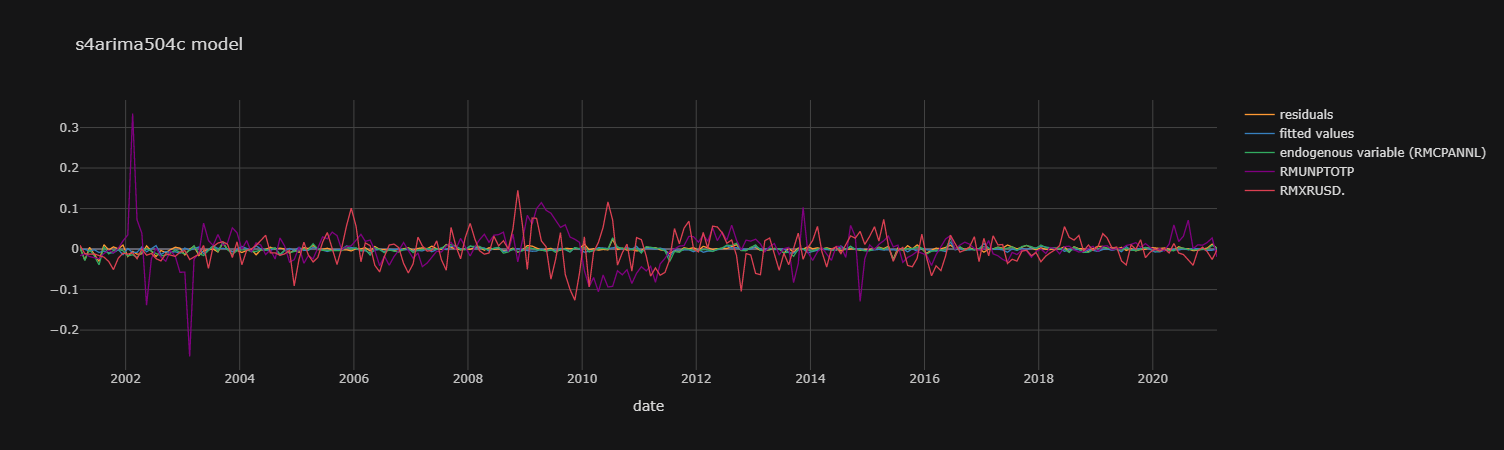

In [64]:
s4arima504c_fit_plot_dic = {
    'residuals' : s4arima504c_fit.resid,
    'fitted values' : s4arima504c_fit.fittedvalues,
    'endogenous variable (RMCPANNL)' : np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())}

exogenous_variables = ["RMUNPTOTP", "RMXRUSD."]
for j,k in zip([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()
                for i in exogenous_variables],
               exogenous_variables):
    s4arima504c_fit_plot_dic[k] = np.array(j).T
    
s4arima504c_fit_plot_df = pd.DataFrame(data = s4arima504c_fit_plot_dic,
                                       index = df.dropna()["RMCPANNL"]["yoy1d"][1:].index)

s4arima504c_fit_plot_df.iplot(theme = "solar",
                              title = "s4arima504c model",
                              xTitle = "date")

#### Recursive One-Step-Ahead Out-of-Sample Forecasts <a class="anchor" id="recursiveonestepaheadoutofsampleforecasts"></a>

Now we can simply apply our model but train it on a smaller dataset (say 80% of our data, *i.e.*: approx. 200 first observations) to simulate an out-of-sample test:

In [65]:
s4arima504c_osaoosf = []

for t in range(200, len(df.dropna()["RMCPANNL"]["yoy1d"][1:])):
    if t%10 == 0 : print(str(t)) # This line is to see the progression of our code.
    s4arima504c = ARIMA(
        endog = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[0:t-1],
        exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[0:t-1]
                         for i in ["RMUNPTOTP", "RMXRUSD."]]).T,
        order = (5, 0, 4),
        trend = "c",
        seasonal_order = (4, 0, 0, 12))
    
    s4arima504c_isf = s4arima504c.fit() # 'isf' for in-sample-fit
    
    s4arima504c_osaoosf.append( # 'osaoosf' as in One-Step-Ahead Out-of-Sample Forecasts
        s4arima504c_isf.forecast(
            exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[t]
                             for i in ["RMUNPTOTP", "RMXRUSD."]]).T)[0])

200
210
220
230


Let's save our data in ```s4arima504c_osaoosf```:

In [66]:
# saving data into a pickle file::
pickle_out = open("s4arima504c_osaoosf.pickle","wb")
pickle.dump(s4arima504c_osaoosf, pickle_out)
pickle_out.close()

# # loading data from the pickle file:
# pickle_in = open('s4arima504c_osaoosf.pickle','rb') # ' rb ' stand for 'read bytes'.
# s4arima504c_osaoosf = pickle.load(pickle_in)
# pickle_in.close() # We ought to close the file we opened to allow any other programs access if they need it.

In [67]:
RMCPANNL_array_wna = np.append( # 'wna' as in 'with na' value added at the end.
    np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[200 + 1:],
    [np.nan])

In [68]:
from datetime import datetime

In [69]:
# add a month to the index:
index_in_qu = df.dropna()["RMCPANNL"]["yoy1d"][1:][200:].index
index = [i for i in index_in_qu][1:] + [
    str(datetime.strptime(str(pd.to_datetime(
        [str(i) for i in  index_in_qu])[-1].replace(
        month = pd.to_datetime(str(df.index[-1])).month+1)),
                          '%Y-%m-%d %H:%M:%S'))[:10]]

In [70]:
s4arima504c_osaoosf_plot_dic = {
    'Recursive One-Step-Ahead Out-of-Sample Forecasts' : np.array(s4arima504c_osaoosf),
    'endogenous variable (RMCPANNL)' : RMCPANNL_array_wna}

exogenous_variables = ["RMUNPTOTP", "RMXRUSD."]
for j,k in zip([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[200:]
                for i in exogenous_variables],
               exogenous_variables):
    s4arima504c_osaoosf_plot_dic[k] = np.array(j).T

s4arima504c_osaoosf_plot_df = pd.DataFrame(
    data = s4arima504c_osaoosf_plot_dic,
    index = index)

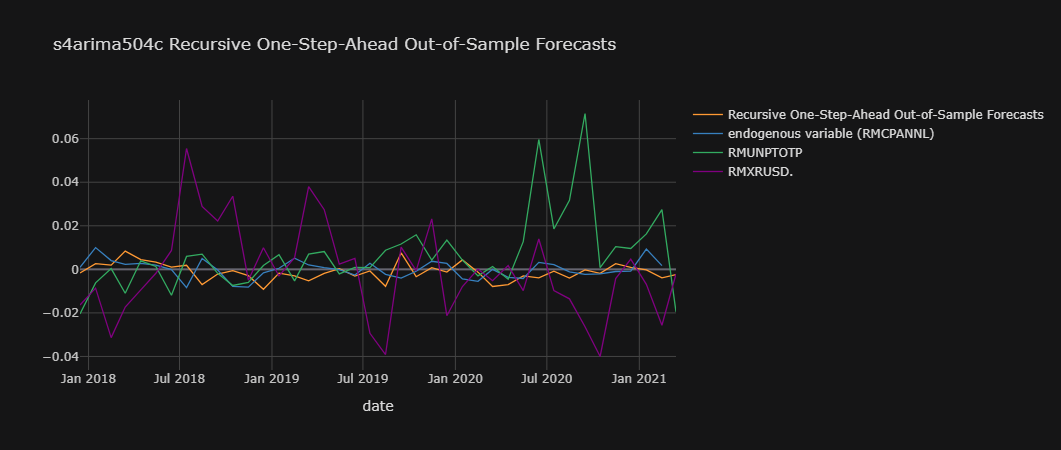

In [71]:
s4arima504c_osaoosf_plot_df.iplot(
    theme = "solar", xTitle = "date",
    title = "s4arima504c Recursive One-Step-Ahead Out-of-Sample Forecasts")

In [72]:
df2 = df.copy()

In [73]:
s4arima504c_osaoosf_plot_df.tail()

Recursive One-Step-Ahead Out-of-Sample Forecasts  \
2020-11-15                                          0.002583   
2020-12-15                                          0.000892   
2021-01-15                                         -0.000282   
2021-02-15                                         -0.003894   
2021-03-15                                         -0.002453   

            endogenous variable (RMCPANNL)  RMUNPTOTP  RMXRUSD.  
2020-11-15                         -0.0010   0.010439 -0.004213  
2020-12-15                         -0.0008   0.009587  0.004651  
2021-01-15                          0.0093   0.016295 -0.006874  
2021-02-15                          0.0017   0.027456 -0.025684  
2021-03-15                             NaN  -0.019498 -0.002158

In [74]:
df2["RMCPANNL", "s4arima504c Recursive OSAOOSF"] = s4arima504c_osaoosf_plot_df["Recursive One-Step-Ahead Out-of-Sample Forecasts"]

In [75]:
df2 = df2.sort_index(axis=1) # This rearranges the columns and merges Fields under the same Instruments.

In [76]:
df2

Instrument        CLc1                                                     \
Field      Close Price Close Price 30D Moving Average       yoy     yoy1d   
2001-01-15       30.05                         28.535  0.099812       NaN   
2001-02-15        28.8                      29.811333  0.078155 -0.021658   
2001-03-15       26.58                         28.976 -0.042306 -0.120460   
2001-04-15        28.2                          27.25 -0.031823  0.010483   
2001-05-15       28.98                      27.932667  0.057495  0.089317   
...                ...                            ...       ...       ...   
2020-10-15       40.92                      39.479333 -0.290909 -0.037946   
2020-11-15       40.12                      39.577333 -0.283577  0.007332   
2020-12-15       47.59                         43.203 -0.248931  0.034647   
2021-01-15       52.04                      48.701333 -0.189239  0.059692   
2021-02-15       59.73                         53.606 -0.028114  0.161125   

Instrument                      RMCPANNL                 RMGOVBALA            \
Field      s4arima504c Recursive OSAOOSF     yoy   yoy1d       raw       yoy   
2001-01-15                           NaN  0.3990     NaN    -306.1  0.880221   
2001-02-15                           NaN  0.4000  0.0010    -601.2  0.301580   
2001-03-15                           NaN  0.4030  0.0030    -865.2  0.047458   
2001-04-15                           NaN  0.3750 -0.0280   -1087.5 -0.101908   
2001-05-15                           NaN  0.3740 -0.0010   -1404.5  0.026831   
...                                  ...     ...     ...       ...       ...   
2020-10-15                     -0.001873  0.0224 -0.0021  -76512.0  1.815788   
2020-11-15                      0.002583  0.0214 -0.0010  -85981.9  1.474314   
2020-12-15                      0.000892  0.0206 -0.0008 -105906.6  1.202753   
2021-01-15                     -0.000282  0.0299  0.0093    -112.3 -0.842607   
2021-02-15                     -0.003894  0.0316  0.0017   -8430.8 -0.198989   

Instrument           RMUNPTOTP                     RMXREUR.            \
Field          yoy1d       raw       yoy     yoy1d      raw       yoy   
2001-01-15       NaN    1032.9 -0.120936       NaN   2.4646  0.322494   
2001-02-15 -0.578641    1032.3 -0.137306 -0.016370   2.4729  0.342435   
2001-03-15 -0.254123     992.8 -0.149053 -0.011747   2.4849  0.340436   
2001-04-15 -0.149365     948.4 -0.167486 -0.018433   2.4880  0.329557   
2001-05-15  0.128739     890.8 -0.188263 -0.020777   2.4910  0.345977   
...              ...       ...       ...       ...      ...       ...   
2020-10-15 -0.003413     285.7  0.104368  0.009587   4.8733  0.025138   
2020-11-15 -0.341474     290.7  0.120663  0.016295   4.8699  0.021307   
2020-12-15 -0.271561     296.1  0.148119  0.027456   4.8707  0.019551   
2021-01-15 -2.045360     292.2  0.128621 -0.019498   4.8728  0.019734   
2021-02-15  0.643618     293.5  0.143358  0.014737   4.8741  0.019089   

Instrument           RMXRUSD.                      
Field          yoy1d      raw       yoy     yoy1d  
2001-01-15       NaN     2.62  0.423913       NaN  
2001-02-15  0.019941     2.68  0.433155  0.009242  
2001-03-15 -0.001999     2.73  0.421875 -0.011280  
2001-04-15 -0.010879     2.79  0.409091 -0.012784  
2001-05-15  0.016420     2.85  0.397059 -0.012032  
...              ...      ...       ...       ...  
2020-10-15 -0.000403     4.14 -0.037209  0.004651  
2020-11-15 -0.003830     4.12 -0.044084 -0.006874  
2020-12-15 -0.001757     4.00 -0.069767 -0.025684  
2021-01-15  0.000183     4.00 -0.071926 -0.002158  
2021-02-15 -0.000645     4.03 -0.079909 -0.007983  

[242 rows x 19 columns]

As you can see, we are missing the last row of data in ```df2```. We can remedy this by appending it with the last row of ```s4arima504c_osaoosf_plot_df```:

In [77]:
df3 = df2.copy() # just to delimitate from before and after this step.

In [78]:
index_of_interest = s4arima504c_osaoosf_plot_df.tail(1).index[0]
df3 = df3.append(pd.Series(name = index_of_interest))

<ipython-input-78-5c005a4a87e5>:2: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [79]:
df3['RMCPANNL', 's4arima504c Recursive OSAOOSF'].loc[index_of_interest] = s4arima504c_osaoosf_plot_df["Recursive One-Step-Ahead Out-of-Sample Forecasts"][-1]

In [80]:
df3

Instrument        CLc1                                                     \
Field      Close Price Close Price 30D Moving Average       yoy     yoy1d   
2001-01-15       30.05                         28.535  0.099812       NaN   
2001-02-15        28.8                      29.811333  0.078155 -0.021658   
2001-03-15       26.58                         28.976 -0.042306 -0.120460   
2001-04-15        28.2                          27.25 -0.031823  0.010483   
2001-05-15       28.98                      27.932667  0.057495  0.089317   
...                ...                            ...       ...       ...   
2020-11-15       40.12                      39.577333 -0.283577  0.007332   
2020-12-15       47.59                         43.203 -0.248931  0.034647   
2021-01-15       52.04                      48.701333 -0.189239  0.059692   
2021-02-15       59.73                         53.606 -0.028114  0.161125   
2021-03-15         NaN                            NaN       NaN       NaN   

Instrument                      RMCPANNL                 RMGOVBALA            \
Field      s4arima504c Recursive OSAOOSF     yoy   yoy1d       raw       yoy   
2001-01-15                           NaN  0.3990     NaN    -306.1  0.880221   
2001-02-15                           NaN  0.4000  0.0010    -601.2  0.301580   
2001-03-15                           NaN  0.4030  0.0030    -865.2  0.047458   
2001-04-15                           NaN  0.3750 -0.0280   -1087.5 -0.101908   
2001-05-15                           NaN  0.3740 -0.0010   -1404.5  0.026831   
...                                  ...     ...     ...       ...       ...   
2020-11-15                      0.002583  0.0214 -0.0010  -85981.9  1.474314   
2020-12-15                      0.000892  0.0206 -0.0008 -105906.6  1.202753   
2021-01-15                     -0.000282  0.0299  0.0093    -112.3 -0.842607   
2021-02-15                     -0.003894  0.0316  0.0017   -8430.8 -0.198989   
2021-03-15                     -0.002453     NaN     NaN       NaN       NaN   

Instrument           RMUNPTOTP                     RMXREUR.            \
Field          yoy1d       raw       yoy     yoy1d      raw       yoy   
2001-01-15       NaN    1032.9 -0.120936       NaN   2.4646  0.322494   
2001-02-15 -0.578641    1032.3 -0.137306 -0.016370   2.4729  0.342435   
2001-03-15 -0.254123     992.8 -0.149053 -0.011747   2.4849  0.340436   
2001-04-15 -0.149365     948.4 -0.167486 -0.018433   2.4880  0.329557   
2001-05-15  0.128739     890.8 -0.188263 -0.020777   2.4910  0.345977   
...              ...       ...       ...       ...      ...       ...   
2020-11-15 -0.341474     290.7  0.120663  0.016295   4.8699  0.021307   
2020-12-15 -0.271561     296.1  0.148119  0.027456   4.8707  0.019551   
2021-01-15 -2.045360     292.2  0.128621 -0.019498   4.8728  0.019734   
2021-02-15  0.643618     293.5  0.143358  0.014737   4.8741  0.019089   
2021-03-15       NaN       NaN       NaN       NaN      NaN       NaN   

Instrument           RMXRUSD.                      
Field          yoy1d      raw       yoy     yoy1d  
2001-01-15       NaN     2.62  0.423913       NaN  
2001-02-15  0.019941     2.68  0.433155  0.009242  
2001-03-15 -0.001999     2.73  0.421875 -0.011280  
2001-04-15 -0.010879     2.79  0.409091 -0.012784  
2001-05-15  0.016420     2.85  0.397059 -0.012032  
...              ...      ...       ...       ...  
2020-11-15 -0.003830     4.12 -0.044084 -0.006874  
2020-12-15 -0.001757     4.00 -0.069767 -0.025684  
2021-01-15  0.000183     4.00 -0.071926 -0.002158  
2021-02-15 -0.000645     4.03 -0.079909 -0.007983  
2021-03-15       NaN      NaN       NaN       NaN  

[243 rows x 19 columns]

### Corresponding Month Model <a class="anchor" id="correspondingmonthmodel"></a>

Many in the industry only focus on the same month of previous years in their predicting models (*e.g.*: only predict this year's March inflation value with previous March values, similarly so with each months of the year). There is some merit to the thought, as other datapoints may sway our data with irrelevant variables. The reason is that demand/supply profiles might be different each month of the day and it would be incorrect to compare months in a continuous series (*i.e.*: January to February *et cetera* (*etc.*)). To do so, we can exploit the SARIMA model and only use Seasonal AutoRegressive variables (in addition to our exogenous variables):

**1st**: Let's check the best SAMIMA model with ARMA(0,0) imposed: <a class="anchor" id="first"></a>

In [81]:
# test0_df, test0_lowest = Reg_Perm_Table(p = [0])

# # To save data out:
# pickle_out = open("Regression_Permutation_Table0.pickle","wb")
# pickle.dump((test0_df, test0_lowest), pickle_out)
# pickle_out.close()

# To load data in:
pickle_in = open("Regression_Permutation_Table0.pickle","rb") # ' rb ' stand for 'read bytes'.
test0_df, test0_lowest = pickle.load(pickle_in)
pickle_in.close() # We ought to close the file we opened to allow any other programs access if they need it.

In [82]:
test0_df[test0_df.index.str.contains("sarima0,0,0")]

AIC         AICC  \
sarima0,0,0,0,0,0,12,c,exo=('CLc1',)               -1656.642285 -1656.540157   
sarima0,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1656.262364 -1656.160236   
sarima0,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1657.350130 -1657.248002   
sarima0,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1664.998503 -1664.896376   
sarima0,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1660.115158 -1660.013030   
...                                                         ...          ...   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1625.696710 -1623.821710   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1632.359703 -1630.484703   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1669.576012 -1667.701012   
sarima0,0,0,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP... -1636.115765 -1634.240765   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1633.772311 -1631.619845   

                                                            BIC         HQIC  \
sarima0,0,0,0,0,0,12,c,exo=('CLc1',)               -1646.212894 -1652.439528   
sarima0,0,0,0,0,0,12,c,exo=('RMGOVBALA',)          -1645.832973 -1652.059607   
sarima0,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)          -1646.920739 -1653.147373   
sarima0,0,0,0,0,0,12,c,exo=('RMXREUR.',)           -1654.569113 -1660.795746   
sarima0,0,0,0,0,0,12,c,exo=('RMXRUSD.',)           -1649.685767 -1655.912400   
...                                                         ...          ...   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1577.026221 -1606.083843   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1583.689213 -1612.746835   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'... -1620.905522 -1649.963145   
sarima0,0,0,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP... -1587.445276 -1616.502898   
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'... -1581.625358 -1612.758525   

                                                         MSE       SSE  
sarima0,0,0,0,0,0,12,c,exo=('CLc1',)                0.000056  0.013325  
sarima0,0,0,0,0,0,12,c,exo=('RMGOVBALA',)           0.000056  0.013346  
sarima0,0,0,0,0,0,12,c,exo=('RMUNPTOTP',)           0.000056  0.013286  
sarima0,0,0,0,0,0,12,c,exo=('RMXREUR.',)            0.000054  0.012868  
sarima0,0,0,0,0,0,12,c,exo=('RMXRUSD.',)            0.000055  0.013133  
...                                                      ...       ...  
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000054  0.012830  
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000052  0.012489  
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMUNPTOTP'...  0.000050  0.011962  
sarima0,0,0,4,0,4,12,c,exo=('RMGOVBALA', 'RMUNP...  0.000052  0.012397  
sarima0,0,0,4,0,4,12,c,exo=('CLc1', 'RMGOVBALA'...  0.000052  0.012413  

[775 rows x 6 columns]

In [83]:
test0_df[test0_df.index.str.contains("sarima0,0,0")].nsmallest(1, 'SSE').index

Index(['sarima0,0,0,3,0,0,12,c,exo=('RMUNPTOTP', 'RMXREUR.', 'RMXRUSD.')'], dtype='object')

Note that our ```Reg_Perm_Table``` function's default Seasonal parameters (```P``` and ```Q```) range from 0 to 5 and that the optimum (*i.e.*: lowest SSE producing one) is lower than 5; this would indicate that we may very well have our optimal SAMIMA model with ARMA(0,0) imposed

**2nd**: Fit the sarima0,0,0,3,0,0,12 model: <a class="anchor" id="#second"></a>

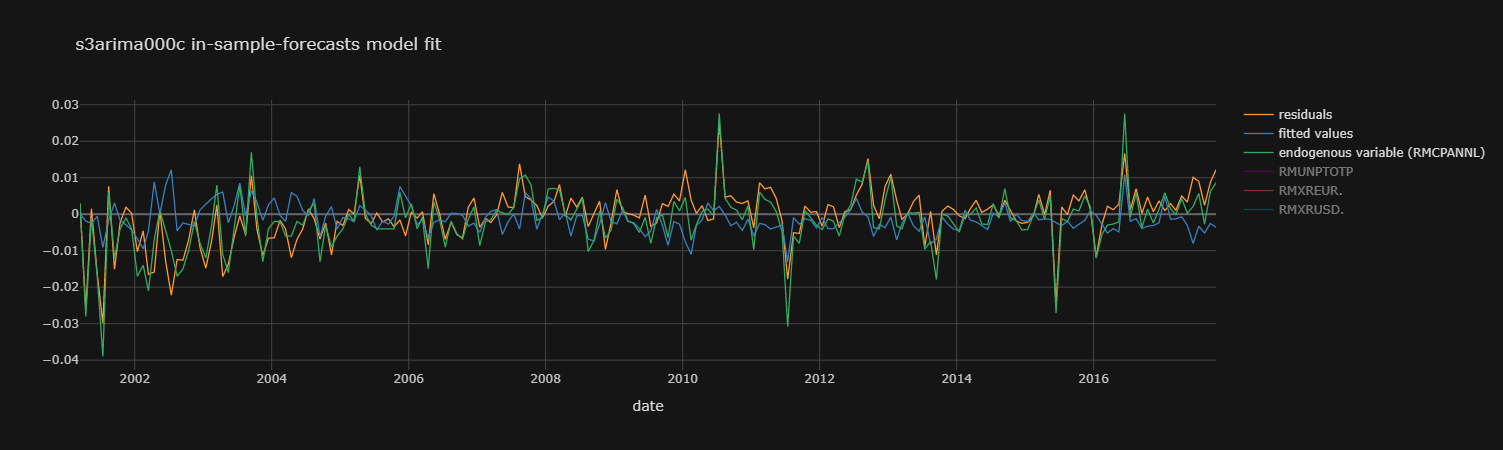

In [84]:
exogenous_variables = ['RMUNPTOTP', 'RMXREUR.', 'RMXRUSD.']

s3arima000c = ARIMA(
    endog = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[0:200],
    exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[0:200]
                     for i in exogenous_variables]).T,
    order = (0, 0, 0),
    trend = "c",
    seasonal_order = (3, 0, 0, 12))
s3arima000c_isf = s3arima000c.fit() # 'isf' for in-sample-fit

s3arima000c_isf_plot_dic = {
    'residuals' : s3arima000c_isf.resid,
    'fitted values' : s3arima000c_isf.fittedvalues,
    'endogenous variable (RMCPANNL)' : np.array(
        df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[0:200]}

for j,k in zip([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[0:200]
                for i in exogenous_variables],
               exogenous_variables):
    s3arima000c_isf_plot_dic[k] = np.array(j).T
    
s3arima000c_isf_plot_df = pd.DataFrame(data = s3arima000c_isf_plot_dic,
                                       index = df.dropna()["RMCPANNL"]["yoy1d"][1:][0:200].index)

s3arima000c_isf_plot_df.iplot(theme = "solar",
                              title = "s3arima000c in-sample-forecasts model fit",
                              xTitle = "date")

**3rd**: Recursive One-Step-Ahead Out-of-Sample Forecasts <a class="anchor" id="#third"></a>

In [85]:
s3arima000c_osaoosf = []

for t in range(200, len(df.dropna()["RMCPANNL"]["yoy1d"][1:])):
    if t%10 == 0 : print("Our code has created one-step-ahead out-of-sample forecasts from 200 to " str(t)) # This line is to see the progression of our code.
    s3arima000c = ARIMA(
        endog = np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[0:t-1],
        exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[0:t-1]
                         for i in exogenous_variables]).T,
        order = (0, 0, 0),
        trend = "c",
        seasonal_order = (3, 0, 0, 12))
    
    s3arima000c_isf = s3arima000c.fit() # 'isf' for in-sample-fit
    
    s3arima000c_osaoosf.append( # 'osaoosf' as in One-Step-Ahead Out-of-Sample Forecasts
        s3arima000c_isf.forecast(
            exog = np.array([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[t]
                             for i in exogenous_variables]).T)[0])

200
210
220
230


Let's save our data in ```s3arima000c_osaoosf```:

In [86]:
# saving data into a pickle file::
pickle_out = open("s3arima000c_osaoosf.pickle","wb")
pickle.dump(s3arima000c_osaoosf, pickle_out)
pickle_out.close()

# # loading data from the pickle file:
# pickle_in = open('s3arima000c_osaoosf.pickle','rb') # ' rb ' stand for 'read bytes'.
# s3arima000c_osaoosf = pickle.load(pickle_in)
# pickle_in.close() # We ought to close the file we opened to allow any other programs access if they need it.

In [87]:
# add a month to the index:
index_in_qu = df.dropna()["RMCPANNL"]["yoy1d"][1:][200:].index
index = [i for i in index_in_qu][1:] + [
    str(datetime.strptime(str(pd.to_datetime(
        [str(i) for i in  index_in_qu])[-1].replace(
        month = pd.to_datetime(str(df.index[-1])).month+1)),
                          '%Y-%m-%d %H:%M:%S'))[:10]]

In [88]:
s3arima000c_osaoosf_plot_dic = {
    'Recursive One-Step-Ahead Out-of-Sample Forecasts' : np.array(s3arima000c_osaoosf),
    'endogenous variable (RMCPANNL)' : np.append(
        np.array(df.dropna()["RMCPANNL"]["yoy1d"][1:].values.tolist())[200 + 1:],
        [np.nan])}

for j,k in zip([df.dropna()[i]["yoy1d"].shift(1)[1:].values.tolist()[200:]
                for i in exogenous_variables],
               exogenous_variables):
    s3arima000c_osaoosf_plot_dic[k] = np.array(j).T

s3arima000c_osaoosf_plot_df = pd.DataFrame(
    data = s3arima000c_osaoosf_plot_dic,
    index = index)

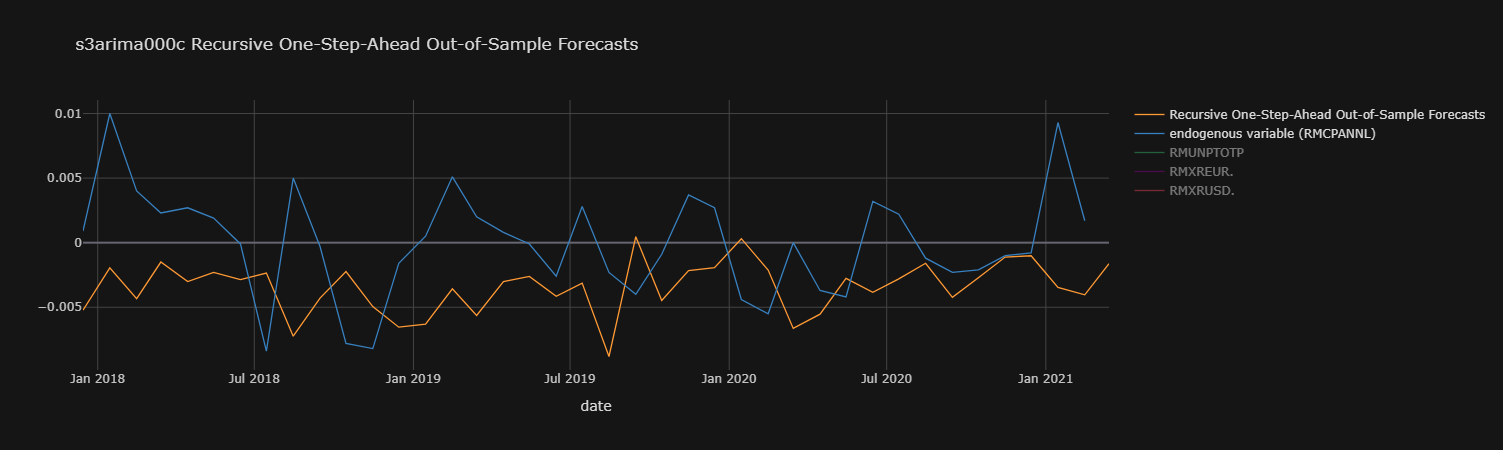

In [89]:
s3arima000c_osaoosf_plot_df.iplot(
    theme = "solar", xTitle = "date",
    title = "s3arima000c Recursive One-Step-Ahead Out-of-Sample Forecasts")

### Comparing Models <a class="anchor" id="#comparingmodels"></a>

In [90]:
for i,j in zip([s3arima000c_osaoosf_plot_df], [s4arima504c_osaoosf_plot_df]):
    s3arima000c_resid = i["endogenous variable (RMCPANNL)"] - i["Recursive One-Step-Ahead Out-of-Sample Forecasts"][:-1]
    s4arima504c_resid = j["endogenous variable (RMCPANNL)"] - j["Recursive One-Step-Ahead Out-of-Sample Forecasts"][:-1]
    s3arima000c_sse = (s3arima000c_resid**2).sum()
    s4arima504c_sse = (s4arima504c_resid**2).sum()

In [91]:
print(s3arima000c_sse, s4arima504c_sse)

0.0013175028279920704 0.0012139805753142835


From the two SSE values above, we can determine that our ```s4arima504c``` model is the better of the two.

## Conclusion <a class="anchor" id="#conclusion"></a>

The fact that a model with seasonal components (SARIMA(5,0,4)(4,0,0)$_{12}$) was the optimal one (even before we investigate Corresponding Month Models) suggests that there was a lot of information in corresponding months in previous years. As a matter of fact, even the directly previous months' coefficients seemed of little relevance. Indeed, ```s4arima504c_fit``` P-values of these cofactors from lag 1 to 4 (```ar.L1``` to ```ar.L4```) never went below 0.1; *i.e.*: they were never statistically significant. The 5th lag however (```ar.L5```, with value 0.2342) had a P-value lower than 0.05, suggesting it to be statistically significant at the 5% Confidence Level (CL). Moving Average elements (```ma.L1``` to ```ma.L4```) never showed statistical significance (as per their P-values). (Statistical significance is only really considered at the 10% CL, when the P-value is lower than 0.1.)

Seasonal coefficients 1 to 3 (```ar.S.L12``` to ```ar.S.L36```) proved significant at the 5% CL. The 4th (```ar.S.L48```) did not.

It would be interesting to look at a non-consecutive lags model with only ```ar.L5``` & ```ar.S.L12``` to ```ar.S.L36``` and investigate it's out-of-sample one-step-ahead forecasts as a back-test.

Additionally, what make this model interesting is that one can use it for more than one-step-ahead forecasts depending on the frequency of exogenous data provision. Say that the exogenous ```RMXRUSD``` variable is only published on the 30th of the month (showing data for the 15th of that month); than one can use data published a month prior to forecast two-steps-ahead, alleviating this issue - although not solving it *per se* (by itself).

Romanian inflation is a particular case study. High inflation levels a the start of our data-set might have skewed results significantly. A look at models such as the ones above in predicting other countries' inflation levels could be more fruitful. Alternatively, looking into more differenced data could be equally interesting. (Indeed, using ```Stationarity_Table``` with more differenced data seem to yield more stationary data.)

## References <a class="anchor" id="#references"></a>

### Model Specifications
* [Time Series Forecasting with SARIMA in Python](https://towardsdatascience.com/time-series-forecasting-with-sarima-in-python-cda5b793977b)
* [Problem defining ARIMA order](https://stats.stackexchange.com/questions/70929/problem-defining-arima-order)
* [Model selection by The Akaike’s Information Criterion (AIC) what is common practice?](https://www.researchgate.net/post/Model_selection_by_The_Akaikes_Information_Criterion_AIC_what_is_common_practice)
* [pmdarima Python Library](https://alkaline-ml.com/pmdarima/index.html)
    * [pmdarima.arima](https://alkaline-ml.com/pmdarima/modules/classes.html)
        * [Tips to using auto_arima](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#tips-and-tricks)
    * [pmdarima.arima.auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)
* [In general, choosing the order of the model (e.g. p, q and P, Q) via information criteria is a good idea, but it is not a good idea to choose the differencing order (d or D) that way.](https://stackoverflow.com/questions/56980547/i-would-like-to-know-sarimastatsmodels-parameter-order-and-seasonal-order)
* [Time Series Talk : Seasonal ARIMA Model](https://www.youtube.com/watch?v=WjeGUs6mzXg)

### Model Performance
* [How to find relative influence of Exogenous variables from a ARIMA model?](https://www.researchgate.net/post/How-to-find-relative-influence-of-Exogenous-variables-from-a-ARIMA-model)
* [Out of sample risk estimates are the gold standard for performance evaluation](https://stats.stackexchange.com/questions/70929/problem-defining-arima-order)

### Academic Refferences

* [FORECASTING INFLATION THROUGH ECONOMETRIC MODELS: AN EMPIRICAL STUDY ON PAKISTANI DATA](https://core.ac.uk/download/pdf/47254426.pdf)
* [Quarterly inflation rate target and forecasts in Romania](file:///C:/Users/U6082174.TEN/OneDrive%20-%20Refinitiv/Projects/Inflation/Docs/Quarterly%20inflation%20rate%20target%20and%20forecasts%20in%20Romania.pdf)
* [THE EVOLUTION OF CONSUMER PRICES IN JANUARY 202](https://insse.ro/cms/sites/default/files/com_presa/com_pdf/ipc01e21.pdf)
* [Concepte de bază și definiții](https://insse.ro/cms/files/statistici/comunicate/ipc/a21/methodological_explanations.pdf)

### Multi-Processing

* [Python Multiprocessing Tutorial: Run Code in Parallel Using the Multiprocessing Module](https://www.youtube.com/watch?v=fKl2JW_qrso)
* [Parallel Processing in Python – A Practical Guide with Examples](https://www.machinelearningplus.com/python/parallel-processing-python/)
* [Multiprocessing in Python on Windows and Jupyter/Ipython — Making it work](https://medium.com/@grvsinghal/speed-up-your-python-code-using-multiprocessing-on-windows-and-jupyter-or-ipython-2714b49d6fac)




* [SEM - Comparing Models with Different Variables](http://www.talkstats.com/threads/sem-comparing-models-with-different-variables.38047/)



### Misalanious

* [Display number with leading zeros](https://stackoverflow.com/questions/134934/display-number-with-leading-zeros)
* [Ordered_unique_values_in_list](https://stackoverflow.com/questions/480214/how-do-you-remove-duplicates-from-a-list-whilst-preserving-order)
* [Select by partial string from a pandas DataFrame](https://stackoverflow.com/questions/11350770/select-by-partial-string-from-a-pandas-dataframe)
* [Jupyter notebook not running code. Stuck on In [*]](https://stackoverflow.com/questions/46383177/jupyter-notebook-not-running-code-stuck-on-in)
* [Modelling](https://davistownsend.github.io/blog/Parallel_ts_fc_Dask/)